In [1]:
from FlagEmbedding import BGEM3FlagModel
from collections import Counter
import copy
import json
import math
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
import pickle
import random
import re
from sentence_transformers import SentenceTransformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, top_k_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from snu_dhc.statistics import classification_metrics, multi_classification_metrics
from snu_dhc.statistics import youden_metrics, auc_score, binary_outcome_analysis, bootstrap_ci
from snu_dhc.tables import DemoTable
import swifter
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
import warnings
#warnings.filterwarnings('ignore')
import xgboost as xgb
from ydata_profiling import ProfileReport
from scipy import sparse
from typing import Literal, Optional

import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint, TQDMProgressBar
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting.metrics.point import CrossEntropy, RMSE
from pytorch_forecasting.metrics.base_metrics import MultiLoss, MultiHorizonMetric
from lightning.pytorch.utilities.model_summary import ModelSummary
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, NaNLabelEncoder
from pytorch_forecasting.data.encoders import MultiNormalizer, TorchNormalizer
from torchmetrics.functional.classification import binary_auroc, multiclass_auroc
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4090


# Base data processing

In [27]:
base_data = pd.read_excel(r"H:\Data\SNUH_SUPREME_2018-2024\snuh_2018-2024_base.xlsx")
print(len(base_data))
base_data.head()

389427


,id,er_dt,dc_dt,age,sex,onset_dt,cc,injury,entry,ems,dx1,dx1_name,init_nurse_dt,init_avpu,init_sbp,init_dbp,init_hr,init_rr,init_bt,init_spo2,ktas_code,ktas_level,er_result,er_disposition1,er_disposition2,init_nurse_note,dx2_1,dx2_2,dx2_3,dx2_4,dx2_5,stroke_cp,stemi_cp,cag,transfusion,intubation,ventilator,vasopressor,er_year
0,R-1731-00000001-2018-01-20-1345,2018-01-20 13:45:00,2018-01-20 14:24:23,77,0,2018-01-19 13:49:00,Bruise,0.0,0.0,0.0,M754,Impingement syndrome of shoulder,2018-01-20 13:51:24,1.0,150.0,81.0,89.0,18.0,36.5,96.0,AQNBJ59,5.0,11.0,0.0,0.0,"시술부위 통증과 부종, bruise 로 내원함",G20,S22440,M79180,M5410,NaN,0,0,0,0,0,0,0,2018
1,R-1731-00000034-2018-02-11-1027,2018-02-11 10:27:00,2018-02-11 17:59:00,85,1,2018-02-11 03:00:00,vomiting,0.0,0.0,0.0,A099,Gastroenteritis and colitis of unspecified origin,2018-02-11 10:50:39,1.0,126.0,56.0,116.0,16.0,37.2,92.0,AJFCE39,3.0,11.0,0.0,0.0,금일 새벽 N/V/D 있어 내원함,N178,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,2018
2,R-1731-00000034-2018-01-15-1611,2018-01-15 16:11:00,2018-01-15 19:31:00,84,1,2018-01-13 16:00:00,dyspnea,0.0,0.0,0.0,J4499,"Chronic obstructive pulmonary disease, unspeci...",2018-01-15 16:38:45,1.0,138.0,72.0,96.0,28.0,36.3,92.0,AHAAD29,2.0,31.0,2.0,1.0,2일 전부터 dyspnea 심해졌고 금일 내과 진료후 AECOPD 소견으로 refer,J9609,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,2018
3,R-1731-00000071-2018-01-23-0632,2018-01-23 06:32:00,2018-01-23 13:18:11,75,0,2018-01-23 06:00:00,Low abd. pain,0.0,0.0,1.0,K5909,Other and unspecified constipation,2018-01-23 06:59:32,1.0,150.0,95.0,115.0,16.0,36.5,98.0,AJABB39,3.0,11.0,0.0,0.0,"5일동안 constipation, low. abd pain 있어 관장하였고,\n금일...",NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,2018
4,R-1731-00000071-2018-02-01-1107,2018-02-01 11:07:00,2018-02-01 20:42:44,75,0,2018-01-25 00:00:00,"pain, chest",0.0,0.0,1.0,I509,"Heart failure, unspecified",2018-02-01 13:06:32,1.0,122.0,86.0,107.0,22.0,36.1,100.0,AIDAI39,3.0,21.0,1.0,1.0,"1/25 응급실 귀가한 저녁부터 chest pain, dyspnea, 가슴답답함 있...",I351,I251,K5909,N178,NaN,0,0,0,0,0,0,0,2018


In [4]:
data1 = copy.deepcopy(base_data)

count = len(data1)
data1 = data1[data1['age']>=18]
print("Including adults:", len(data1), count-len(data1))

count = len(data1)
data1 = data1[pd.notnull(data1['er_result'])]
print("Excluding ed disposition missing:", len(data1), count-len(data1))

count = len(data1)
data1 = data1[data1['er_result']!=41]
print("Excluding DOA:", len(data1), count-len(data1))

count = len(data1)
data1 = data1[~data1['er_result'].isin([12, 13])]
print("Excluding hopeless discharge:", len(data1), count-len(data1))

count = len(data1)
data1 = data1[~data1['er_result'].isin([14, 18])]
print("Excluding AMA or disappear:", len(data1), count-len(data1))

count = len(data1)
data1 = data1[data1['injury'].isin([0,1])]
print("Excluding 진료외:", len(data1), count-len(data1))

count = len(data1)
data1 = data1[pd.notnull(data1['dx1'])]
print("Excluding diagnosis missing:", len(data1), count-len(data1))

count = len(data1)
data1['er_los'] = (data1['dc_dt'] - data1['er_dt']).dt.total_seconds()/3600        # Calculate in hours
data1 = data1[(0 <= data1['er_los'])&(data1['er_los'] <= 24*14)]
print("Remove data with error in ED times:", len(data1), count-len(data1))

data1.reset_index(inplace=True, drop=True)
data1['er_disposition3'] = data1['er_disposition2'].apply(lambda x: 2 if x>=2 else x)
data1

Including adults: 279374 110053
Excluding ed disposition missing: 278352 1022
Excluding DOA: 278096 256
Excluding hopeless discharge: 277463 633
Excluding AMA or disappear: 272228 5235
Excluding 진료외: 272096 132
Excluding diagnosis missing: 272093 3
Remove data with error in ED times: 272058 35


,id,er_dt,dc_dt,age,sex,onset_dt,cc,injury,entry,ems,dx1,dx1_name,init_nurse_dt,init_avpu,init_sbp,init_dbp,init_hr,init_rr,init_bt,init_spo2,ktas_code,ktas_level,er_result,er_disposition1,er_disposition2,init_nurse_note,dx2_1,dx2_2,dx2_3,dx2_4,dx2_5,stroke_cp,stemi_cp,cag,transfusion,intubation,ventilator,vasopressor,er_year,er_year_group,er_los,er_disposition3
0,R-1731-00000001-2018-01-20-1345,2018-01-20 13:45:00,2018-01-20 14:24:23,77,0,2018-01-19 13:49:00,Bruise,0.0,0.0,0.0,M754,Impingement syndrome of shoulder,2018-01-20 13:51:24,1.0,150.0,81.0,89.0,18.0,36.5,96.0,AQNBJ59,5.0,11.0,0.0,0.0,"시술부위 통증과 부종, bruise 로 내원함",G20,S22440,M79180,M5410,NaN,0,0,0,0,0,0,0,2018,0,0.656389,0.0
1,R-1731-00000034-2018-02-11-1027,2018-02-11 10:27:00,2018-02-11 17:59:00,85,1,2018-02-11 03:00:00,vomiting,0.0,0.0,0.0,A099,Gastroenteritis and colitis of unspecified origin,2018-02-11 10:50:39,1.0,126.0,56.0,116.0,16.0,37.2,92.0,AJFCE39,3.0,11.0,0.0,0.0,금일 새벽 N/V/D 있어 내원함,N178,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,2018,0,7.533333,0.0
2,R-1731-00000034-2018-01-15-1611,2018-01-15 16:11:00,2018-01-15 19:31:00,84,1,2018-01-13 16:00:00,dyspnea,0.0,0.0,0.0,J4499,"Chronic obstructive pulmonary disease, unspeci...",2018-01-15 16:38:45,1.0,138.0,72.0,96.0,28.0,36.3,92.0,AHAAD29,2.0,31.0,2.0,1.0,2일 전부터 dyspnea 심해졌고 금일 내과 진료후 AECOPD 소견으로 refer,J9609,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,2018,0,3.333333,1.0
3,R-1731-00000071-2018-01-23-0632,2018-01-23 06:32:00,2018-01-23 13:18:11,75,0,2018-01-23 06:00:00,Low abd. pain,0.0,0.0,1.0,K5909,Other and unspecified constipation,2018-01-23 06:59:32,1.0,150.0,95.0,115.0,16.0,36.5,98.0,AJABB39,3.0,11.0,0.0,0.0,"5일동안 constipation, low. abd pain 있어 관장하였고,\n금일...",NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,2018,0,6.769722,0.0
4,R-1731-00000071-2018-02-01-1107,2018-02-01 11:07:00,2018-02-01 20:42:44,75,0,2018-01-25 00:00:00,"pain, chest",0.0,0.0,1.0,I509,"Heart failure, unspecified",2018-02-01 13:06:32,1.0,122.0,86.0,107.0,22.0,36.1,100.0,AIDAI39,3.0,21.0,1.0,1.0,"1/25 응급실 귀가한 저녁부터 chest pain, dyspnea, 가슴답답함 있...",I351,I251,K5909,N178,NaN,0,0,0,0,0,0,0,2018,0,9.595556,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272053,R-1731-00224855-2024-12-30-0315,2024-12-30 03:15:00,2024-12-30 05:06:33,27,1,NaT,TA-Traffic accident,1.0,0.0,1.0,S010,Open wound of scalp,2024-12-30 03:28:19,1.0,NaN,NaN,NaN,NaN,NaN,NaN,ACHBC29,2.0,31.0,2.0,1.0,80km/h로 달리던 택시의 뒷자석 승객으로\n2A32경 화물차와 충돌하여 택시 뒷...,V495,S0621,NaN,NaN,NaN,0,0,0,0,0,0,0,2024,2,1.859167,1.0
272054,R-1731-00224859-2024-12-31-2347,2024-12-31 23:47:00,2025-01-01 00:34:42,33,0,2024-12-31 20:00:00,for delivery,0.0,1.0,1.0,O4291,"Premature rupture of membranes, unspecified",2025-01-01 00:20:11,1.0,140.0,90.0,72.0,16.0,37.2,98.0,AKHCE29,2.0,31.0,2.0,1.0,35wks1 산모\n8P 양수 파막으로 타원 방문하여 분만 위해 내원함\n- 산과 ...,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,2024,2,0.795000,1.0
272055,R-1731-00224866-2024-12-31-2355,2024-12-31 23:55:00,2025-01-01 03:22:37,47,1,NaT,TA-Traffic accident,1.0,0.0,1.0,S0650,Traumatic subdural haemorrhage,2025-01-01 00:16:38,1.0,134.0,92.0,92.0,16.0,NaN,95.0,ANBBC29,2.0,31.0,2.0,1.0,연희교차로 지하차도 오토바이 대 오토바이TA \n속도 파악 안되나 오토바이 앞 파손...,S02650,S02490,S899,S02680,S52590,0,0,0,0,0,0,0,2024,2,3.460278,1.0
272056,R-1731-00224867-2024-12-31-0918,2024-12-31 09:18:00,2024-12-31 20:23:03,55,1,2024-12-30 20:30:00,"motor weakness, leg",0.0,0.0,0.0,G951,Vascular myelopathies,2024-12-31 09:24:12,1.0,163.0,107.0,93.0,20.0,37.2,98.0,AMACA29,2.0,31.0,2.0,1.0,"3주전부터 요통, 12/30 local OS(방병원)에서 MRI 찍었고 \ndisc...",G959,M512,NaN,NaN,NaN,0,0,0,0,0,0,0,2024,2,11.084167,1.0


In [5]:
# Check if there are any duplicate ids

len(set(data1['id']))

272058

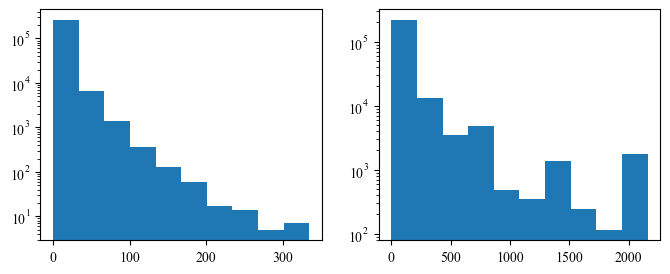

,er_los,sx_onset
count,272058.000000,245947.000000
mean,8.694831,103.667914
std,12.069598,255.901774
min,0.073611,0.000000
25%,2.913333,4.866667
50%,5.029167,23.733333
75%,9.211111,85.316667
max,334.765556,2160.000000


In [5]:
# Get ed_los, sx_onset


data1['sx_onset'] = (data1['er_dt'] - data1['onset_dt']).dt.total_seconds()/3600   # Calculate in hours
data1['sx_onset'] = data1['sx_onset'].apply(lambda x: 24*90 if x > 24*90 else x)       # Clip at 90 days
data1['sx_onset'] = data1['sx_onset'].apply(lambda x: np.nan if x < 0 else x)          # If negative np.nan

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.hist(data1['er_los'], log=True)
plt.subplot(1,2,2)
plt.hist(data1['sx_onset'], log=True)
plt.show()

data1[['er_los', 'sx_onset']].describe()

In [7]:
# Check for non-plausible values for statics

data1[['age', 'sex', 'injury', 'entry', 'ems', 'ktas_level', 'er_year']].describe()

,age,sex,injury,entry,ems,ktas_level,er_year
count,272058.000000,272058.000000,272058.000000,272054.000000,270805.000000,272058.000000,272058.000000
mean,58.203707,0.483140,0.105367,0.141071,0.218268,3.169401,2020.512575
std,18.674275,0.499717,0.307027,0.348096,0.413071,0.831583,1.945239
min,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2018.000000
25%,45.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2019.000000
50%,62.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2020.000000
75%,73.000000,1.000000,0.000000,0.000000,0.000000,4.000000,2022.000000
max,111.000000,1.000000,1.000000,1.000000,1.000000,5.000000,2024.000000


In [8]:
# Check for the number of unique chief complaints
len(set(data1['cc']))

1028

In [8]:
data2 = data1.copy()
data2 = data2.rename(columns={'er_disposition3': 'disposition'})

In [9]:
# Make base dataframe

columns = ['id', 'timestep', 'age', 'sx_onset', 'init_nurse_encoded', 
           'sex', 'injury', 'entry', 'ems', 'ktas_level',
           'time_of_day', 'day_of_week', 'disposition']

data2 = data2.loc[data2.index.repeat(data2['er_los'].astype(int) + 1)].copy()
data2['timestep'] = data2.groupby(level=0).cumcount()
data2['time_of_day'] = data2['er_dt'].dt.hour + data2['timestep']
data2['day_of_week'] = data2.apply(lambda x: x['er_dt'] + pd.Timedelta(hours=x['timestep']), axis=1).dt.dayofweek
data2 = data2[columns]
data2['disposition'] = data2['disposition'].astype(int)
data2

,id,timestep,age,sx_onset,init_nurse_encoded,sex,injury,entry,ems,ktas_level,er_year_group,time_of_day,day_of_week,stroke_cp,dx1_1,dx1_2,dx1_3,disposition
0,R-1731-00000001-2018-01-20-1345,0,77,23.933333,"[-0.18339352, -0.03034042, 0.068239436, 0.0055...",0,0.0,0.0,0.0,5.0,0,13,5,0,12,7,5,0
1,R-1731-00000034-2018-02-11-1027,0,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,10,6,0,0,0,9,0
1,R-1731-00000034-2018-02-11-1027,1,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,11,6,0,0,0,9,0
1,R-1731-00000034-2018-02-11-1027,2,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,12,6,0,0,0,9,0
1,R-1731-00000034-2018-02-11-1027,3,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,13,6,0,0,0,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272056,R-1731-00224867-2024-12-31-0918,10,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,19,1,0,6,9,5,1
272056,R-1731-00224867-2024-12-31-0918,11,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,20,1,0,6,9,5,1
272057,R-1731-00224868-2024-12-31-0603,0,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,6,1,0,8,7,2,2
272057,R-1731-00224868-2024-12-31-0603,1,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,7,1,0,8,7,2,2


# Vital data add

In [14]:
vital_dict = {
    'sbp': {'label': ['SBP', 'ASBP', 'ASBP2'], 'data': pd.DataFrame()},
    'dbp': {'label': ['DBP', 'ADBP', 'ADBP2'], 'data': pd.DataFrame()},
    'hr': {'label': ['HR', 'PR'], 'data': pd.DataFrame()},
    'rr': {'label': ['RR', 'RR(연동)', 'RR-vent'], 'data': pd.DataFrame()},
    'bt': {'label': ['BT', 'BT2'], 'data': pd.DataFrame()},
    'spo2': {'label': ['SpO2'], 'data': pd.DataFrame()},
}

In [78]:
# 활력징후 검사 데이터 불러오기

vital_columns = ['id', '연구별 환자 ID', '응급실입실시간', '기록작성일시', '간호항목', 'VALUE']

for year in [2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    print(f"Starting to analyze year {year}") 
    for season in tqdm(range(1,11,3)):
        start_m, end_m = f"{str(season).zfill(2)}", f"{str(season+2).zfill(2)}"
        filename = f"H:/Data/SNUH_SUPREME_2018-2024/{year}/{year}{start_m}-{year}{end_m}_13_활력징후.xlsx"
        vital_data = pd.read_excel(filename)
        vital_data['id'] = vital_data['연구별 환자 ID'] + "-" + pd.to_datetime(vital_data['응급실입실시간']).dt.strftime('%Y-%m-%d-%H%M')
        
        for key, value in vital_dict.items():
            one_data = vital_data[vital_data['간호항목'].isin(value['label'])][vital_columns]
            value['data'] = pd.concat([value['data'], one_data])
            value['data'] = value['data'].reset_index(drop=True)


Starting to analyze year 2018


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:35<00:00, 84.00s/it]


Starting to analyze year 2019


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:50<00:00, 87.66s/it]


Starting to analyze year 2020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:16<00:00, 94.04s/it]


Starting to analyze year 2021


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:12<00:00, 93.07s/it]


Starting to analyze year 2022


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:57<00:00, 89.44s/it]


Starting to analyze year 2023


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:20<00:00, 80.15s/it]


Starting to analyze year 2024


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:08<00:00, 62.00s/it]


In [79]:
'''
with open(f'H:/Data/SNUH_SUPREME_2018-2024/snuh_2018-2024_vital_dict.pickle', 'wb') as f:
    pickle.dump(vital_dict, f, pickle.HIGHEST_PROTOCOL)
'''

In [10]:
with open(f'H:/Data/SNUH_SUPREME_2018-2024/snuh_2018-2024_vital_dict.pickle', 'rb') as f:
    vital_dict = pickle.load(f)

In [11]:
def string_to_float(x):
    try:
        return float(x)
    except:
        return np.nan

for var in ['sbp', 'dbp', 'hr', 'rr', 'bt', 'spo2']:
    vital_data = vital_dict[var]['data']
    vital_data['er_dt'] = pd.to_datetime(vital_data['응급실입실시간'])
    vital_data['vital_dt'] = pd.to_datetime(vital_data['기록작성일시'], errors='coerce')
    vital_data['timestep'] = (vital_data['vital_dt'] - vital_data['er_dt']).dt.total_seconds() // 3600 + 1
    vital_data[var] = vital_data['VALUE'].apply(string_to_float)
    vital_data = vital_data[['id', 'timestep', var]]
    vital_data = vital_data[pd.notnull(vital_data[var])]

    init_vital_data = data1[['id', 'init_'+var]].copy()
    init_vital_data['timestep'] = 0
    init_vital_data = init_vital_data.rename(columns={'init_'+var: var})
    init_vital_data = init_vital_data[pd.notnull(init_vital_data[var])]

    vital_data = pd.concat([vital_data, init_vital_data], ignore_index=True)
    vital_data[var] = vital_data[var].astype(float)
    vital_data = vital_data.groupby(['id', 'timestep']).agg('mean').reset_index()
    
    data2 = data2.merge(vital_data, how='left', on=['id', 'timestep'])

data2

,id,timestep,age,sx_onset,init_nurse_encoded,sex,injury,entry,ems,ktas_level,er_year_group,time_of_day,day_of_week,stroke_cp,dx1_1,dx1_2,dx1_3,disposition,sbp,dbp,hr,rr,bt,spo2
0,R-1731-00000001-2018-01-20-1345,0,77,23.933333,"[-0.18339352, -0.03034042, 0.068239436, 0.0055...",0,0.0,0.0,0.0,5.0,0,13,5,0,12,7,5,0,150.000000,81.000000,89.000000,18.000000,36.5,96.000000
1,R-1731-00000034-2018-02-11-1027,0,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,10,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000
2,R-1731-00000034-2018-02-11-1027,1,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,11,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000
3,R-1731-00000034-2018-02-11-1027,2,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,12,6,0,0,0,9,0,NaN,NaN,NaN,NaN,38.8,NaN
4,R-1731-00000034-2018-02-11-1027,3,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,13,6,0,0,0,9,0,84.333333,50.000000,100.666667,NaN,NaN,90.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180063,R-1731-00224867-2024-12-31-0918,10,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,19,1,0,6,9,5,1,140.161290,88.129032,78.327869,16.096774,-1.0,99.933333
2180064,R-1731-00224867-2024-12-31-0918,11,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,20,1,0,6,9,5,1,144.380952,93.238095,78.642857,15.428571,NaN,99.952381
2180065,R-1731-00224868-2024-12-31-0603,0,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,6,1,0,8,7,2,2,128.000000,72.000000,75.000000,16.000000,36.0,99.000000
2180066,R-1731-00224868-2024-12-31-0603,1,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,7,1,0,8,7,2,2,119.000000,74.666667,84.000000,17.000000,36.0,99.500000


# Lab data add

In [12]:
lab_dict = {
    'wbc': {'label': ['WBC(검사24시간가능)'], 'data': pd.DataFrame()},
    'seg': {'label': ['Segmented neutrophil'], 'data': pd.DataFrame()},
    'hb': {'label': ['Hb(검사24시간가능)'], 'data': pd.DataFrame()},
    'plt': {'label': ['PLT(검사24시간가능)'], 'data': pd.DataFrame()},
    'crp': {'label': ["hs-CRP quantitation(검사24시간가능)"], 'data': pd.DataFrame()},
    'ast': {'label': ['GOT (AST)(검사24시간가능)', 'GOT (AST) [piccolo, 과내간이]'], 'data': pd.DataFrame()},
    'alt': {'label': ['GPT (ALT)(검사24시간가능)', 'GPT(ALT) [piccolo, 과내간이]'], 'data': pd.DataFrame()},
    'alp': {'label': ['Alkaline phosphatase(검사24시간가능)', 'Alkaline phosphatase [piccolo, 과내간이]'], 'data': pd.DataFrame()},
    'tb': {'label': ['Bilirubin, total(검사24시간가능)', 'Bilirubin, total [piccolo, 과내간이]'], 'data': pd.DataFrame()},
    'bun': {'label': ['BUN(검사24시간가능)', 'BUN [piccolo, 과내간이]'], 'data': pd.DataFrame()},
    'cr': {'label': ['Creatinine(검사24시간가능)', 'Creatinine [piccolo, 과내간이]'], 'data': pd.DataFrame()},
    'glucose': {'label': ['Glucose(검사24시간가능)', 'Glucose [piccolo, 과내간이]', '[POCT, ABGA]Glucose'], 'data': pd.DataFrame()},
    'protein': {'label': ['Protein, total(검사24시간가능)', 'Protein, total [piccolo, 과내간이]'], 'data': pd.DataFrame()},
    'albumin': {'label': ['Albumin(검사24시간가능)', 'Albumin [piccolo, 과내간이]'], 'data': pd.DataFrame()},
    'calcium': {'label': ['Calcium(검사24시간가능)'], 'data': pd.DataFrame()},
    'phosphorus': {'label': ['Phosphorus(검사24시간가능)'], 'data': pd.DataFrame()},
    'sodium': {'label': ['Sodium (serum)(검사24시간가능)'], 'data': pd.DataFrame()},
    'potassium': {'label': ['Potassium (serum)(검사24시간가능)'], 'data': pd.DataFrame()},
    'chloride': {'label': ['Chloride (serum)(검사24시간가능)'], 'data': pd.DataFrame()},
    'tco2': {'label': ['CO2, total (serum)(검사24시간가능)', 'CO2, total [piccolo, 과내간이]'], 'data': pd.DataFrame()},
    'ph': {'label': ['pH[POCT]'], 'data': pd.DataFrame()},
    'bicarbonate': {'label': ['HCO3- [POCT]'], 'data': pd.DataFrame()},
    'lactic': {'label': ['[POCT, ABGA]Lactic acid'], 'data': pd.DataFrame()},
    'inr': {'label': ['PT (INR)'], 'data': pd.DataFrame()},
    'pt': {'label': ['PT (sec)'], 'data': pd.DataFrame()},
    'aptt': {'label': ['aPTT (검사24시간가능)', 'aPTT(검사24시간가능)'], 'data': pd.DataFrame()},
    'ck': {'label': ['CK (CPK)(검사24시간가능)'], 'data': pd.DataFrame()},
    'ckmb': {'label': ['CKMB(검사24시간가능)'], 'data': pd.DataFrame()},
    'tni': {'label': ['Troponin I(검사24시간가능)'], 'data': pd.DataFrame()},
    'bnp': {'label': ['B-type Natriuretic Peptide(BNP)(검사24시간가능)'], 'data': pd.DataFrame()},
    'probnp': {'label': ['NT-proBNP (N-terminal pro B-type natriuretic peptide)(검사24시간가능)'], 'data': pd.DataFrame()},
    'urine_wbc': {'label': ['WBC stick'], 'data': pd.DataFrame()},
    'urine_nit': {'label': ['Nitrite'], 'data': pd.DataFrame()},
}

In [13]:
# 검사 데이터 불러오기

lab_columns = ['id', '연구별 환자 ID', '응급실입실시간', '검사시행일', '검사명', '검사결과', '채혈일시']

for year in [2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    print(f"Starting to analyze year {year}") 
    for season in tqdm(range(1,11,3)):
        start_m, end_m = f"{str(season).zfill(2)}", f"{str(season+2).zfill(2)}"
        filename = f"H:/Data/SNUH_SUPREME_2018-2024/{year}/{year}{start_m}-{year}{end_m}_7_진단검사.xlsx"
        lab_data = pd.read_excel(filename)
        lab_data['id'] = lab_data['연구별 환자 ID'] + "-" + pd.to_datetime(lab_data['응급실입실시간']).dt.strftime('%Y-%m-%d-%H%M')
        
        for key, value in lab_dict.items():
            one_data = lab_data[lab_data['검사명'].isin(value['label'])][lab_columns]
            value['data'] = pd.concat([value['data'], one_data])
            value['data'] = value['data'].reset_index(drop=True)


Starting to analyze year 2018


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [07:32<00:00, 113.20s/it]


Starting to analyze year 2019


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [07:58<00:00, 119.72s/it]


Starting to analyze year 2020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:38<00:00, 99.61s/it]


Starting to analyze year 2021


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [06:42<00:00, 100.56s/it]


Starting to analyze year 2022


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [07:09<00:00, 107.42s/it]


Starting to analyze year 2023


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:55<00:00, 88.86s/it]


Starting to analyze year 2024


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:49<00:00, 87.47s/it]


In [14]:
"""
with open(f'H:/Data/SNUH_SUPREME_2018-2024/snuh_2018-2024_lab_dict.pickle', 'wb') as f:
    pickle.dump(lab_dict, f, pickle.HIGHEST_PROTOCOL)
"""

In [ ]:
with open(f'H:/Data/SNUH_SUPREME_2018-2024/snuh_2018-2024_lab_dict.pickle', 'rb') as f:
    lab_dict = pickle.load(f)

In [15]:
def clean_float(x):
    if pd.isnull(x):
        return np.nan
    # Remove non-numeric and non-dot characters
    cleaned = re.sub(r'[^0-9.]', '', str(x))
    # Must not be just "." or contain more than one "."
    if cleaned == '.' or cleaned.count('.') > 1:
        return np.nan
    try:
        return float(cleaned)
    except ValueError:
        return np.nan

def ua_clean_float(x):
    if pd.isnull(x):
        return np.nan

    if x in ['1+', '+']:
        return 1
    elif x == '2+':
        return 2
    elif x == '3+':
        return 3
    else:
        return 0
    

for var in lab_dict.keys():
    lab_data = lab_dict[var]['data']
    lab_data['er_dt'] = pd.to_datetime(lab_data['응급실입실시간'])
    lab_data['lab_dt'] = pd.to_datetime(lab_data['채혈일시'], errors='coerce')
    lab_data['timestep'] = (lab_data['lab_dt'] - lab_data['er_dt']).dt.total_seconds() //3600 + 1

    if var not in ['ph', 'bicarbonate', 'lactic']:
        lab_data['timestep'] += 1                         # POCT 결과는 채혈한 timestep에 결과 나오고, 그 외는 다음 timestep에 결과 나온다고 가정

    if var in ['urine_wbc', 'urine_nit']:
        lab_data[var] = lab_data['검사결과'].apply(ua_clean_float)
    else:
        lab_data[var] = lab_data['검사결과'].apply(clean_float)
        
    lab_data = lab_data[['id', 'timestep', var]]
    lab_data = lab_data[pd.notnull(lab_data[var])]

    lab_data = lab_data.groupby(['id', 'timestep']).agg('mean').reset_index()
    
    data2 = data2.merge(lab_data, how='left', on=['id', 'timestep'])

data2

,id,timestep,age,sx_onset,init_nurse_encoded,sex,injury,entry,ems,ktas_level,er_year_group,time_of_day,day_of_week,stroke_cp,dx1_1,dx1_2,dx1_3,disposition,sbp,dbp,hr,rr,bt,spo2,wbc,...,tb,bun,cr,glucose,protein,albumin,calcium,phosphorus,sodium,potassium,chloride,tco2,ph,bicarbonate,lactic,inr,pt,aptt,ck,ckmb,tni,bnp,probnp,urine_wbc,urine_nit
0,R-1731-00000001-2018-01-20-1345,0,77,23.933333,"[-0.18339352, -0.03034042, 0.068239436, 0.0055...",0,0.0,0.0,0.0,5.0,0,13,5,0,12,7,5,0,150.000000,81.000000,89.000000,18.000000,36.5,96.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,R-1731-00000034-2018-02-11-1027,0,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,10,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R-1731-00000034-2018-02-11-1027,1,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,11,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,R-1731-00000034-2018-02-11-1027,2,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,12,6,0,0,0,9,0,NaN,NaN,NaN,NaN,38.8,NaN,7.22,...,NaN,NaN,NaN,NaN,NaN,NaN,8.3,2.2,140.0,4.0,103.0,NaN,NaN,NaN,NaN,1.03,12.1,30.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R-1731-00000034-2018-02-11-1027,3,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,13,6,0,0,0,9,0,84.333333,50.000000,100.666667,NaN,NaN,90.666667,NaN,...,1.4,26.0,1.60,124.0,5.4,3.0,NaN,NaN,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180063,R-1731-00224867-2024-12-31-0918,10,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,19,1,0,6,9,5,1,140.161290,88.129032,78.327869,16.096774,-1.0,99.933333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180064,R-1731-00224867-2024-12-31-0918,11,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,20,1,0,6,9,5,1,144.380952,93.238095,78.642857,15.428571,NaN,99.952381,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180065,R-1731-00224868-2024-12-31-0603,0,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,6,1,0,8,7,2,2,128.000000,72.000000,75.000000,16.000000,36.0,99.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180066,R-1731-00224868-2024-12-31-0603,1,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,7,1,0,8,7,2,2,119.000000,74.666667,84.000000,17.000000,36.0,99.500000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.3,24.6,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Text data add

In [31]:
with open(f'H:/Data/SNUH_SUPREME_2018-2024/snuh_2018-2024_text_data.pickle', 'rb') as f:
    text_data = pickle.load(f)

In [57]:
with open(f'H:/Data/SNUH_SUPREME_2018-2024/snuh_2018-2024_consult_data.pickle', 'rb') as f:
    consult_data = pickle.load(f)

In [30]:
def text_preprocess(row):
    text = row['note']
    cleaned_text = ''
    
    if row['서식명']=='응급의학과(EMO)_응급기록_FREE TEXT':
        cleaned_text += text['PI <- 소견 및 계획'].replace('_x000D_', '\n')
        cleaned_text += '\n\n'
        cleaned_text += text['PHX-과거병력 <- 소견 및 계획'].replace('_x000D_', '\n')
        cleaned_text += '\n\n'
        cleaned_text += text['ROS <- 소견 및 계획'].replace('_x000D_', '\n')
        cleaned_text += '\n\n'
        cleaned_text += text['PE <- 소견 및 계획'].replace('_x000D_', '\n')
        cleaned_text += '\n\n'
        cleaned_text += text['Assessment <- 소견 및 계획'].replace('_x000D_', '\n')
    elif row['서식명']=='병원공통_응급기록_전문의 초진기록 연동':
        cleaned_text += text['전문의 초진기록 <- 소견 및 계획'].replace('_x000D_', '\n')
    elif row['서식명']=='병원공통_응급기록_New Free Text':
        cleaned_text += text['PI/PE <- 소견 및 계획'].replace('_x000D_', '\n')
        cleaned_text += '\n\n'
        cleaned_text += text['Assessment <- 소견 및 계획'].replace('_x000D_', '\n')
    else:
        cleaned_text += ''
    return cleaned_text

text_data['er_dt'] = pd.to_datetime(text_data['id'].apply(lambda x: x[-15:]), errors='coerce')
text_data['note_dt'] = pd.to_datetime(text_data['서식작성일'], errors='coerce')
text_data['timestep'] = (text_data['note_dt'] - text_data['er_dt']).dt.total_seconds() // 3600 + 1

text_data['physician_note'] = text_data.apply(lambda x: text_preprocess(x), axis=1)
text_data

,id,서식작성일,서식명,note,er_dt,note_dt,timestep,physician_note
0,R-1731-00000001-2018-01-20-1345,2018-01-20 14:20:30.0,응급의학과(EMO)_응급기록_FREE TEXT,{'PE <- 소견 및 계획': 'Rt neck area_x000D_ 3cm pal...,2018-01-20 13:45:00,2018-01-20 14:20:30,1.0,#. Myofascial pain syndrome multiple site\n\n\...
1,R-1731-00000034-2018-01-15-1611,2018-01-15 16:38:06.0,응급의학과(EMO)_응급기록_FREE TEXT,"{'Plan <- 소견 및 계획': 'W/U and Adm_x000D_ ', 'PI...",2018-01-15 16:11:00,2018-01-15 16:38:06,1.0,#1. CKD with renal stones \n\n- 2014.12 Cr 0.9...
2,R-1731-00000034-2018-01-15-1611,2018-01-15 17:23:26.0,병원공통_응급기록_전문의 초진기록 연동,{'전문의 초진기록 <- 소견 및 계획': 'KTAS : 2 활력징후 - 수축기...,2018-01-15 16:11:00,2018-01-15 17:23:26,2.0,KTAS : 2\n활력징후\n - 수축기혈압 : 138 mmHg\n - 이완기혈...
3,R-1731-00000034-2018-02-11-1027,2018-02-11 11:11:50.0,응급의학과(EMO)_응급기록_FREE TEXT,"{'Plan <- 소견 및 계획': 'w/u, sx control_x000D_ ',...",2018-02-11 10:27:00,2018-02-11 11:11:50,1.0,#1. CKD with renal stones\n\n- 2014.12 Cr 0.95...
4,R-1731-00000034-2018-02-11-1027,2018-02-11 13:35:49.0,병원공통_응급기록_New Free Text,{'PI/PE <- 소견 및 계획': '#1. CKD with renal stone...,2018-02-11 10:27:00,2018-02-11 13:35:49,4.0,#1. CKD with renal stones\n\n- 2014.12 Cr 0.95...
...,...,...,...,...,...,...,...,...
713715,R-1731-00224865-2024-12-31-1142,2024-12-31 12:06:41.0,병원공통_응급기록_전문의 초진기록 연동,{'전문의 초진기록 <- 소견 및 계획': 'KTAS : 4 활력징후 - 수축기...,2024-12-31 11:42:00,2024-12-31 12:06:41,1.0,KTAS : 4\n활력징후\n - 수축기혈압 : 159 mmHg\n - 이완기혈...
713716,R-1731-00224866-2024-12-31-2355,2025-01-01 00:08:22.0,병원공통_응급기록_전문의 초진기록 연동,{'전문의 초진기록 <- 소견 및 계획': 'KTAS : 2 활력징후 - 수축기...,2024-12-31 23:55:00,2025-01-01 00:08:22,1.0,KTAS : 2\n활력징후\n - 수축기혈압 : 134 mmHg\n - 이완기혈...
713717,R-1731-00224867-2024-12-31-0918,2024-12-31 09:41:44.0,병원공통_응급기록_전문의 초진기록 연동,{'전문의 초진기록 <- 소견 및 계획': 'KTAS : 2 활력징후 - 수축기...,2024-12-31 09:18:00,2024-12-31 09:41:44,1.0,KTAS : 2\n활력징후\n - 수축기혈압 : 163 mmHg\n - 이완기혈...
713718,R-1731-00224867-2024-12-31-0918,2024-12-31 10:03:38.0,응급의학과(EMO)_응급기록_FREE TEXT,"{'혈압 <- 활력징후 <- PE <- 소견 및 계획': '163/107', '맥박...",2024-12-31 09:18:00,2024-12-31 10:03:38,1.0,상환 하기 병력 있으신 분으로 3주 전부터 LBP 있어 24.12.30 local ...


In [21]:
def consult_preprocess(row):
    text = row['note']
    cleaned_text = ''

    try:
        if row['서식명']=='병원공통_타과의뢰_FREE TEXT':
            cleaned_text += text['의뢰내용'].replace('_x000D_', '\n')
        elif row['서식명']=='본원응급실(AER)_타과회신':
            cleaned_text += text['회신내용 <- 회신내용'].replace('_x000D_', '\n')
        elif row['서식명']=='소화기내과_타과회신':
            cleaned_text += text['recommendations <- 회신내용'].replace('_x000D_', '\n')
        elif row['서식명']=='병원공통_타과회신_FREE TEXT':
            cleaned_text += text['내용 <- 회신내용'].replace('_x000D_', '\n')
        elif row['서식명']=='내분비내과_타과회신(ENDO)':
            cleaned_text += text['Opinion <- 회신내용'].replace('_x000D_', '\n')
        elif row['서식명']=='감염내과_타과회신_default':
            cleaned_text += text['Opinions or Recommendations <- 회신내용'].replace('_x000D_', '\n')
        elif row['서식명']=='완화의료임상윤리센터_타과의뢰':
            cleaned_text += text['완화의료센터 의뢰 이유_x000D_\n(중복 가능) <- 의뢰내용'].replace('_x000D_', '\n')
        elif row['서식명']=='정신건강의학과_타과회신_CGI':
            cleaned_text += text['회신내용 <- 회신내용'].replace('_x000D_', '\n')
        else:
            cleaned_text += ''
    except:
        cleaned_text += ''
    return cleaned_text

consult_data['er_dt'] = pd.to_datetime(consult_data['id'].apply(lambda x: x[-15:]), errors='coerce')
consult_data['note_dt'] = pd.to_datetime(consult_data['서식작성일'], errors='coerce')
consult_data['timestep'] = (consult_data['note_dt'] - consult_data['er_dt']).dt.total_seconds() // 3600 + 1

consult_data['physician_note'] = consult_data.apply(lambda x: consult_preprocess(x), axis=1)
consult_data

,id,서식작성일,서식명,note,er_dt,note_dt,timestep,physician_note
0,R-1731-00000034-2018-01-15-1611,2018-01-15 17:22:18.0,병원공통_타과의뢰_FREE TEXT,"{'의뢰의사 <- 병원공통_타과의뢰_FREE TEXT': '신소미', '의뢰내용':...",2018-01-15 16:11:00,2018-01-15 17:22:18,2.0,안녕하십니까 선생님\n\n\n\n상기환자 COPD 에 대해 호흡기내과 김영환 교수님...
1,R-1731-00000034-2018-01-15-1611,2018-01-15 18:12:36.0,본원응급실(AER)_타과회신,{'회신내용 <- 회신내용': '외래에서 anoro사용 중_x000D_ _x000D...,2018-01-15 16:11:00,2018-01-15 18:12:36,3.0,외래에서 anoro사용 중\n\n\n\nS>\n\ndyspnea 악화 but 가래량...
2,R-1731-00000034-2018-02-11-1027,2018-02-11 17:43:09.0,병원공통_타과의뢰_FREE TEXT,"{'수신의사 <- 병원공통_타과의뢰_FREE TEXT': '이현정', '진단': '...",2018-02-11 10:27:00,2018-02-11 17:43:09,8.0,본 의뢰는 응급의료센터 진료 후 외래 경과 관찰이 필요한 환자의 적절한 진료를 위해...
3,R-1731-00000034-2018-02-11-1027,2018-02-12 08:33:53.0,소화기내과_타과회신,{'recommendations <- 회신내용': '응급실 퇴원환자입니다. 외래에서...,2018-02-11 10:27:00,2018-02-12 08:33:53,23.0,응급실 퇴원환자입니다. 외래에서 진료하겠습니다.\n\n\n\n소화기내과 이현정 배상...
4,R-1731-00000071-2018-01-25-1406,2018-01-25 19:35:33.0,병원공통_타과의뢰_FREE TEXT,"{'환자위치 <- 병원공통_타과의뢰_FREE TEXT': '응급실', '진단': '...",2018-01-25 14:06:00,2018-01-25 19:35:33,6.0,안녕하세요 교수님 \n\n\n\n환자분 PT 연장되어 응급실로 refer된 분입니다...
...,...,...,...,...,...,...,...,...
619295,R-1731-00224868-2024-12-31-0603,2024-12-31 06:40:33.0,본원응급실(AER)_타과회신,"{'환자진료시각 <- 회신내용': '2024-12-31T06:34:00', '추적관...",2024-12-31 06:03:00,2024-12-31 06:40:33,1.0,"R/O impending rupture, right CIA \n\n\n\nSICU2..."
619296,R-1731-00224868-2024-12-31-0603,2024-12-31 06:41:40.0,병원공통_타과의뢰_FREE TEXT,"{'진단': 'R/O pseudoaneurysm, right CIA_x000D_ '...",2024-12-31 06:03:00,2024-12-31 06:41:40,1.0,환자 동맥경화로 12/30 local에서 Rt common iliac atery s...
619297,R-1731-00224868-2024-12-31-0603,2024-12-31 06:42:28.0,병원공통_타과의뢰_FREE TEXT,"{'환자위치 <- 병원공통_타과의뢰_FREE TEXT': '응급실', '의뢰의사 <...",2024-12-31 06:03:00,2024-12-31 06:42:28,1.0,환자 동맥경화로 12/30 local에서 Rt common iliac atery s...
619298,R-1731-00224868-2024-12-31-0603,2024-12-31 07:48:30.0,본원응급실(AER)_타과회신,"{'추적관찰 시기 <- 추적관찰 및 소요시간 <- 회신내용': '해당없음', '10...",2024-12-31 06:03:00,2024-12-31 07:48:30,2.0,외과계 중환자실에서 peri-procedure period 동안 manage 하겠습...


In [22]:
text_data['physician_note'] = '응급기록:\n' + text_data['physician_note']
text_data = text_data[['id', 'timestep', 'physician_note']]

consult_data['physician_note'] = '타과의뢰/타과회신:\n' + consult_data['physician_note']
consult_data = consult_data[['id', 'timestep', 'physician_note']]

physician_data = pd.concat([text_data, consult_data], ignore_index=True)
physician_data

,id,timestep,physician_note
0,R-1731-00000001-2018-01-20-1345,1.0,응급기록:\n#. Myofascial pain syndrome multiple si...
1,R-1731-00000034-2018-01-15-1611,1.0,응급기록:\n#1. CKD with renal stones \n\n- 2014.12...
2,R-1731-00000034-2018-01-15-1611,2.0,응급기록:\nKTAS : 2\n활력징후\n - 수축기혈압 : 138 mmHg\n ...
3,R-1731-00000034-2018-02-11-1027,1.0,응급기록:\n#1. CKD with renal stones\n\n- 2014.12 ...
4,R-1731-00000034-2018-02-11-1027,4.0,응급기록:\n#1. CKD with renal stones\n\n- 2014.12 ...
...,...,...,...
1333015,R-1731-00224868-2024-12-31-0603,1.0,"타과의뢰/타과회신:\nR/O impending rupture, right CIA \..."
1333016,R-1731-00224868-2024-12-31-0603,1.0,타과의뢰/타과회신:\n환자 동맥경화로 12/30 local에서 Rt common i...
1333017,R-1731-00224868-2024-12-31-0603,1.0,타과의뢰/타과회신:\n환자 동맥경화로 12/30 local에서 Rt common i...
1333018,R-1731-00224868-2024-12-31-0603,2.0,타과의뢰/타과회신:\n외과계 중환자실에서 peri-procedure period 동...


In [23]:
physician_data = physician_data.groupby(['id', 'timestep']).agg('sum').reset_index()
physician_data

,id,timestep,physician_note
0,R-1731-00000001-2018-01-20-1345,1.0,응급기록:\n#. Myofascial pain syndrome multiple si...
1,R-1731-00000001-2018-08-30-1153,1.0,"응급기록:\n# IBS IMG pf. 임종필\n\n# PTC, s/p total (..."
2,R-1731-00000001-2018-08-30-1153,2.0,응급기록:\nKTAS : 3\n활력징후\n - 수축기혈압 : 155 mmHg\n ...
3,R-1731-00000001-2019-12-10-1637,1.0,응급기록:\nKTAS : 3\n활력징후\n - 수축기혈압 : 146 mmHg\n ...
4,R-1731-00000001-2019-12-10-1637,5.0,타과의뢰/타과회신:\n본 의뢰는 응급의료센터 진료 후 외래 경과 관찰이 필요한 환자...
...,...,...,...
892294,R-1731-00224867-2024-12-31-0918,1.0,응급기록:\nKTAS : 2\n활력징후\n - 수축기혈압 : 163 mmHg\n ...
892295,R-1731-00224867-2024-12-31-0918,3.0,타과의뢰/타과회신:\n안녕하십니까 선생님\n\n\n\n상기병력의 환자로 내원 3주 ...
892296,R-1731-00224868-2024-12-31-0603,1.0,응급기록:\nKTAS : 3\n활력징후\n - 수축기혈압 : 128 mmHg\n ...
892297,R-1731-00224868-2024-12-31-0603,2.0,타과의뢰/타과회신:\n외과계 중환자실에서 peri-procedure period 동...


In [24]:
# Encode physician_note into vector of (128,) and use all zero vector for missings
document_embeddings = text_model.encode_document(list(physician_data['physician_note'].values), show_progress_bar=True)
truncated = document_embeddings[:,:128]
norms = np.linalg.norm(truncated, axis=1, keepdims=True)
document_embeddings = truncated / norms

physician_data['physician_note_encoded'] = pd.Series([row for row in document_embeddings])
physician_data['physician_note_encoded'] = physician_data.apply(lambda x: np.zeros(128,) if x.physician_note == '' else x.physician_note_encoded, axis=1)
physician_data['physician_note_encoded']

Batches:   0%|          | 0/27885 [00:00<?, ?it/s]

0         [-0.086761475, 0.074733324, -0.06120941, -0.01...
1         [-0.046827197, 0.074304536, -0.03007603, 0.050...
2         [-0.013668291, 0.045104396, 0.047895346, 0.047...
3         [-0.06085911, 0.12055285, 0.029388908, 0.06756...
4         [-0.20308167, 0.109399855, 0.031028036, 0.0459...
                                ...                        
892294    [-0.06548881, 0.11491489, 0.008576924, 0.09590...
892295    [-0.11350368, 0.03863463, 0.04940691, 0.079473...
892296    [-0.09787979, 0.04123412, 0.07247463, 0.095624...
892297    [-0.1654437, 0.056234565, 0.0099673355, 0.0159...
892298    [-0.07280964, 0.10899121, 0.015658816, 0.04721...
Name: physician_note_encoded, Length: 892299, dtype: object

In [25]:
"""
with open(f'H:/Data/SNUH_SUPREME_2018-2024/snuh_2018-2024_physician_data_new.pickle', 'wb') as f:
    pickle.dump(physician_data, f, pickle.HIGHEST_PROTOCOL)
"""

In [16]:
with open(f'H:/Data/SNUH_SUPREME_2018-2024/snuh_2018-2024_physician_data_new.pickle', 'rb') as f:
    physician_data = pickle.load(f)

In [17]:
data2 = data2.merge(physician_data[['id', 'timestep', 'physician_note_encoded']], how='left', on=['id', 'timestep'])
data2

,id,timestep,age,sx_onset,init_nurse_encoded,sex,injury,entry,ems,ktas_level,er_year_group,time_of_day,day_of_week,stroke_cp,dx1_1,dx1_2,dx1_3,disposition,sbp,dbp,hr,rr,bt,spo2,wbc,...,bun,cr,glucose,protein,albumin,calcium,phosphorus,sodium,potassium,chloride,tco2,ph,bicarbonate,lactic,inr,pt,aptt,ck,ckmb,tni,bnp,probnp,urine_wbc,urine_nit,physician_note_encoded
0,R-1731-00000001-2018-01-20-1345,0,77,23.933333,"[-0.18339352, -0.03034042, 0.068239436, 0.0055...",0,0.0,0.0,0.0,5.0,0,13,5,0,12,7,5,0,150.000000,81.000000,89.000000,18.000000,36.5,96.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,R-1731-00000034-2018-02-11-1027,0,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,10,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R-1731-00000034-2018-02-11-1027,1,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,11,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.08392765, 0.0834402, 0.012432238, 0.069508..."
3,R-1731-00000034-2018-02-11-1027,2,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,12,6,0,0,0,9,0,NaN,NaN,NaN,NaN,38.8,NaN,7.22,...,NaN,NaN,NaN,NaN,NaN,8.3,2.2,140.0,4.0,103.0,NaN,NaN,NaN,NaN,1.03,12.1,30.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R-1731-00000034-2018-02-11-1027,3,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,13,6,0,0,0,9,0,84.333333,50.000000,100.666667,NaN,NaN,90.666667,NaN,...,26.0,1.60,124.0,5.4,3.0,NaN,NaN,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180063,R-1731-00224867-2024-12-31-0918,10,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,19,1,0,6,9,5,1,140.161290,88.129032,78.327869,16.096774,-1.0,99.933333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180064,R-1731-00224867-2024-12-31-0918,11,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,20,1,0,6,9,5,1,144.380952,93.238095,78.642857,15.428571,NaN,99.952381,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180065,R-1731-00224868-2024-12-31-0603,0,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,6,1,0,8,7,2,2,128.000000,72.000000,75.000000,16.000000,36.0,99.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180066,R-1731-00224868-2024-12-31-0603,1,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,7,1,0,8,7,2,2,119.000000,74.666667,84.000000,17.000000,36.0,99.500000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.3,24.6,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.09787979, 0.04123412, 0.07247463, 0.095624..."


# Image data add

In [28]:
image_dict = {
    'chest_xr': {'label': ['RG2'], 'data': pd.DataFrame()},
    'abd_xr': {'label': ['RG3'], 'data': pd.DataFrame()},
    'chest_ct': {'label': ['RC3', 'RC5', 'RC15'], 'data': pd.DataFrame()},
    'abd_ct': {'label': ['RC4', 'RC10', 'RC16', ], 'data': pd.DataFrame()},
    'brain_ct': {'label': ['RC1', 'RC2', 'RC12', 'RC13'], 'data': pd.DataFrame()},
    'other_ct': {'label': ['RC6', 'RC7', 'RC14', 'RC17', 'RC18'], 'data': pd.DataFrame()},
    'out_ct': {'label': ['RZ4'], 'data': pd.DataFrame()},
    'brain_mr': {'label': ['RM1', 'RM2'], 'data': pd.DataFrame()},
    'other_mr': {'label': ['RM3', 'RM4', 'RM5', 'RM6', 'RM8'], 'data': pd.DataFrame()},
    'out_mr': {'label': ['RZ3'], 'data': pd.DataFrame()}
}

In [126]:
image_columns = ['id', '연구별 환자 ID', '응급실입실시간', '검사시행일', '검사명', '검사결과', '처방전표분류코드', '처방전표분류']
    
for year in tqdm([2018, 2019, 2020, 2021, 2022, 2023, 2024]):
    print(f"Starting to analyze year {year}") 
    
    filename = f"H:/Data/SNUH_SUPREME_2018-2024/{year}/{year}_8_영상검사.xlsx"
    
    image_data = pd.read_excel(filename)
    image_data = image_data.iloc[:,:-3]
    image_data['id'] = image_data['연구별 환자 ID'] + "-" + pd.to_datetime(image_data['응급실입실시간']).dt.strftime('%Y-%m-%d-%H%M')

    for key, value in image_dict.items():
        if key == 'abd_ct':
            one_data = image_data[(image_data['처방전표분류코드'].isin(value['label']))|(image_data['검사명']=='CT Angio + 3D Aorta (abdominal)(contrast)')]
        else:
            one_data = image_data[(image_data['처방전표분류코드'].isin(value['label']))&(image_data['검사명']!='CT Angio + 3D Aorta (abdominal)(contrast)')]
        one_data = one_data[image_columns]
        value['data'] = pd.concat([value['data'], one_data])
        value['data'] = value['data'].reset_index(drop=True)

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Starting to analyze year 2018


 14%|████████████                                                                        | 1/7 [00:19<01:59, 19.88s/it]

Starting to analyze year 2019


 29%|████████████████████████                                                            | 2/7 [00:42<01:46, 21.34s/it]

Starting to analyze year 2020


 43%|████████████████████████████████████                                                | 3/7 [00:59<01:17, 19.46s/it]

Starting to analyze year 2021


 57%|████████████████████████████████████████████████                                    | 4/7 [01:14<00:52, 17.59s/it]

Starting to analyze year 2022


 71%|████████████████████████████████████████████████████████████                        | 5/7 [01:29<00:33, 16.89s/it]

Starting to analyze year 2023


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [01:47<00:17, 17.02s/it]

Starting to analyze year 2024


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:59<00:00, 17.08s/it]


In [127]:
"""
with open(f'H:/Data/SNUH_SUPREME_2018-2024/snuh_2018-2024_image_dict.pickle', 'wb') as f:
    pickle.dump(image_dict, f, pickle.HIGHEST_PROTOCOL)
"""

In [31]:
with open(f'H:/Data/SNUH_SUPREME_2018-2024/snuh_2018-2024_image_dict.pickle', 'rb') as f:
    image_dict = pickle.load(f)

In [32]:
def ctmr_preprocess(row):
    if pd.isnull(row['검사결과']):
        return ''
    text = f"{row['검사명']}: \n{row['검사결과']}"
    cleaned_text = text.replace('_x000D_', '\n')
    return cleaned_text 

def xr_preprocess(row):
    if pd.isnull(row['검사결과']):
        return ''
    text = f"{row['검사명']}: \n{row['검사결과']}"
    cleaned_text = text.replace('_x000D_', '\n')
    cleaned_text = re.sub(r'\[Finding\].*', '', cleaned_text, flags=re.DOTALL)
    return cleaned_text 

total_image_data = pd.DataFrame()

for var in image_dict.keys():
    image_data = image_dict[var]['data']
    image_data['er_dt'] = pd.to_datetime(image_data['응급실입실시간'])
    image_data['image_dt'] = pd.to_datetime(image_data['검사시행일'], errors='coerce')
    image_data['timestep'] = (image_data['image_dt'] - image_data['er_dt']).dt.total_seconds() // 3600 + 1
    image_data['timestep'] += 1                         # 다음 timestep에 판독문 나온다고 가정

    if var in ['chest_xr', 'abd_xr']:
        image_data['result'] = image_data.apply(xr_preprocess, axis=1)
    else:
        image_data['result'] = image_data.apply(ctmr_preprocess, axis=1)
        
    image_data = image_data[['id', 'timestep', 'result']]
    total_image_data = pd.concat([total_image_data, image_data], ignore_index=True)

In [33]:
total_image_data = total_image_data.groupby(['id', 'timestep']).agg('sum').reset_index()
total_image_data

,id,timestep,result
0,R-1731-00000001-2018-08-30-1153,2.0,Chest AP: \n[Conclusion]\n\nNo significant int...
1,R-1731-00000001-2018-08-30-1153,7.0,CT Chest Routine (contrast): \n[Conclusion]\n\...
2,R-1731-00000001-2019-12-10-1637,2.0,Chest PA: \n[Conclusion]\n\nSlightly increased...
3,R-1731-00000001-2019-12-10-1637,4.0,CT Chest + 3D (contrast): \n[Conclusion]\n\nIn...
4,R-1731-00000002-2023-01-16-1046,2.0,Chest AP: \n[Conclusion]\n\nMild Rt. lung hazi...
...,...,...,...
393804,R-1731-00224876-2018-12-13-1121,3.0,Chest AP: \n[Conclusion]\n\nNo remarkable find...
393805,R-1731-00224877-2019-07-18-1747,3.0,Abdomen Erect: \n[Conclusion]\n\nNonspecific b...
393806,R-1731-00224877-2019-11-25-1811,2.0,Abdomen Erect: \n[Conclusion]\n\nNo remarkable...
393807,R-1731-00224883-2023-05-27-1450,2.0,Abdomen Erect: \n[Conclusion]\n\nNonspecific b...


In [21]:
for var in ['chest_ct', 'abd_ct', 'brain_ct', 'other_ct', 'brain_mr', 'other_mr']:
    var_name = var + '_test'
    one_data = image_dict[var]['data']
    one_data[var_name] = 1
    one_data = one_data.drop_duplicates(subset=['id', 'timestep', var_name], ignore_index=True)
    data2 = data2.merge(one_data[['id', 'timestep', var_name]], how='left', on=['id', 'timestep'])

data2

,id,timestep,age,sx_onset,init_nurse_encoded,sex,injury,entry,ems,ktas_level,er_year_group,time_of_day,day_of_week,stroke_cp,dx1_1,dx1_2,dx1_3,disposition,sbp,dbp,hr,rr,bt,spo2,wbc,...,phosphorus,sodium,potassium,chloride,tco2,ph,bicarbonate,lactic,inr,pt,aptt,ck,ckmb,tni,bnp,probnp,urine_wbc,urine_nit,physician_note_encoded,chest_ct_test,abd_ct_test,brain_ct_test,other_ct_test,brain_mr_test,other_mr_test
0,R-1731-00000001-2018-01-20-1345,0,77,23.933333,"[-0.18339352, -0.03034042, 0.068239436, 0.0055...",0,0.0,0.0,0.0,5.0,0,13,5,0,12,7,5,0,150.000000,81.000000,89.000000,18.000000,36.5,96.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,R-1731-00000034-2018-02-11-1027,0,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,10,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R-1731-00000034-2018-02-11-1027,1,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,11,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.08392765, 0.0834402, 0.012432238, 0.069508...",NaN,NaN,NaN,NaN,NaN,NaN
3,R-1731-00000034-2018-02-11-1027,2,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,12,6,0,0,0,9,0,NaN,NaN,NaN,NaN,38.8,NaN,7.22,...,2.2,140.0,4.0,103.0,NaN,NaN,NaN,NaN,1.03,12.1,30.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R-1731-00000034-2018-02-11-1027,3,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,13,6,0,0,0,9,0,84.333333,50.000000,100.666667,NaN,NaN,90.666667,NaN,...,NaN,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180063,R-1731-00224867-2024-12-31-0918,10,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,19,1,0,6,9,5,1,140.161290,88.129032,78.327869,16.096774,-1.0,99.933333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180064,R-1731-00224867-2024-12-31-0918,11,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,20,1,0,6,9,5,1,144.380952,93.238095,78.642857,15.428571,NaN,99.952381,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180065,R-1731-00224868-2024-12-31-0603,0,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,6,1,0,8,7,2,2,128.000000,72.000000,75.000000,16.000000,36.0,99.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180066,R-1731-00224868-2024-12-31-0603,1,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,7,1,0,8,7,2,2,119.000000,74.666667,84.000000,17.000000,36.0,99.500000,NaN,...,NaN,NaN,NaN,NaN,NaN,7.3,24.6,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.09787979, 0.04123412, 0.07247463, 0.095624...",NaN,NaN,NaN,NaN,NaN,NaN


# 기능 검사 add

In [50]:
function_dict = {
    'echo_test': {'label': ['심초음파검사'], 'data': pd.DataFrame()},
    'endo_test': {'label': ['치료내시경', '진단내시경', '진단내시경검사', '초음파내시경', '치료내시경검사'], 'data': pd.DataFrame()},
}

In [215]:
function_columns = ['id', '응급실입실시간', '검사시행일', '검사명', '검사세부항목명', '검사결과', '처방전표분류코드', '처방전표분류']
    
for year in tqdm([2018, 2019, 2020, 2021, 2022, 2023, 2024]):
    print(f"Starting to analyze year {year}") 
    
    filename = f"H:/Data/SNUH_SUPREME_2018-2024/{year}/{year}_9_기능검사.xlsx"
    
    function_data = pd.read_excel(filename)
    function_data['id'] = function_data['연구별 환자 ID'] + "-" + pd.to_datetime(function_data['응급실입실시간']).dt.strftime('%Y-%m-%d-%H%M')

    for key, value in function_dict.items():
        one_data = function_data[function_data['처방전표분류'].isin(value['label'])]
        one_data = one_data[function_columns]
        value['data'] = pd.concat([value['data'], one_data])
        value['data'] = value['data'].reset_index(drop=True)

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Starting to analyze year 2018


 14%|████████████                                                                        | 1/7 [00:05<00:33,  5.67s/it]

Starting to analyze year 2019


 29%|████████████████████████                                                            | 2/7 [00:09<00:24,  4.82s/it]

Starting to analyze year 2020


 43%|████████████████████████████████████                                                | 3/7 [00:15<00:19,  4.95s/it]

Starting to analyze year 2021


 57%|████████████████████████████████████████████████                                    | 4/7 [00:21<00:16,  5.49s/it]

Starting to analyze year 2022


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:30<00:13,  6.82s/it]

Starting to analyze year 2023


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:41<00:08,  8.35s/it]

Starting to analyze year 2024


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:48<00:00,  6.99s/it]


In [216]:
"""
with open(f'H:/Data/SNUH_SUPREME_2018-2024/snuh_2018-2024_function_dict.pickle', 'wb') as f:
    pickle.dump(function_dict, f, pickle.HIGHEST_PROTOCOL)
"""

In [22]:
with open(f'H:/Data/SNUH_SUPREME_2018-2024/snuh_2018-2024_function_dict.pickle', 'rb') as f:
    function_dict = pickle.load(f)

In [23]:
def endo_preprocess(row):
    if pd.isnull(row['검사결과']):
        return np.nan

    if row['검사세부항목명'] in ['Conclusion <- 소화기내시경 검사 결과 보고서Ⅰ <- 과별서식기본',
                          'Conclusion <- 상부 위장관 내시경 결과 보고서 Ⅰ <- 과별서식기본',
                          'Conclusion <- 하부 위장관 내시경 결과 보고서 Ⅰ <- 과별서식기본',
                          'Conclusion <- 캡슐내시경 검사 결과 보고서Ⅰ <- 과별서식기본',
                          'Conclusion <- 단일 풍선 소장 내시경 결과지 <- 과별서식기본',
                          'Conclusion <- 수면초음파내시경 기록지 <- 과별서식기본',
                          'Conclusion <- 초음파내시경 기록지 <- 과별서식기본',
                          'Conclusion <- 초음파내시경 결과 보고서 I <- 과별서식기본',
                          'Comment <- 내시경적역행성담췌관조영술 기록지(ERCP) <- 과별서식기본',
                          'Procedure Description <- 치료내시경 결과보고서 <- 과별서식기본'
                          ]:
        text = f"{row['검사명']}: \n{row['검사결과']}"
        cleaned_text = text.replace('_x000D_', '\n')
        return cleaned_text 
    else:
        return np.nan

def echo_preprocess(row):
    if pd.isnull(row['검사결과']):
        return np.nan

    text = f"{row['검사명']}: \n{row['검사결과']}"
    cleaned_text = text.replace('_x000D_', '\n')
    return cleaned_text 


total_function_data = pd.DataFrame()

for var in function_dict.keys():
    function_data = function_dict[var]['data']

    if var == 'endo_test':
        function_data['result'] = function_data.apply(lambda x: endo_preprocess(x), axis=1)
    elif var == 'echo_test':
        function_data['result'] = function_data.apply(lambda x: echo_preprocess(x), axis=1)

    function_data = function_data[pd.notnull(function_data['result'])]
    function_data['er_dt'] = pd.to_datetime(function_data['응급실입실시간'])
    function_data['function_dt'] = pd.to_datetime(function_data['검사시행일'], errors='coerce')
    function_data['timestep'] = (function_data['function_dt'] - function_data['er_dt']).dt.total_seconds() // 3600 + 1
    function_data['timestep'] += 1                         # 다음 timestep에 판독문 나온다고 가정
        
    function_data = function_data[['id', 'timestep', 'result']]
    total_function_data = pd.concat([total_function_data, function_data], ignore_index=True)

total_function_data

C:\Users\user\AppData\Local\Temp\ipykernel_53812\339370283.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  function_data['er_dt'] = pd.to_datetime(function_data['응급실입실시간'])
C:\Users\user\AppData\Local\Temp\ipykernel_53812\339370283.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  function_data['function_dt'] = pd.to_datetime(function_data['검사시행일'], errors='coerce')
C:\Users\user\AppData\Local\Temp\ipykernel_53812\339370283.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

,id,timestep,result
0,R-1731-00000017-2018-11-02-1053,4.0,응급센터용 Echocardiography-전문: \n2018-11-02 \n응급센터...
1,R-1731-00000074-2018-05-09-1028,6.0,응급센터용 Echocardiography-전문: \n2018-05-09 \n응급실내...
2,R-1731-00000180-2018-12-03-1019,6.0,응급센터용 Echocardiography-전문: \n2018-12-03 \n응급센터...
3,R-1731-00000283-2018-12-11-2157,18.0,응급센터용 Echocardiography-전문: \n2018-12-12 \n응급센터...
4,R-1731-00000296-2018-01-25-1215,5.0,응급센터용 Echocardiography-전문: \n2018-01-25 \n응급실내...
...,...,...,...
13901,R-1731-00224632-2024-12-15-1308,23.0,위내시경(병동)(소독): \nEso: Free --> insertion 시 확인되지...
13902,R-1731-00224641-2024-12-18-1233,6.0,"대장내시경(병동)(소독): \nDRE: free\n\nRectum, S colon에..."
13903,R-1731-00224703-2024-12-22-1724,22.0,"진정내시경적 담(췌)석 제거술 바스켓,풍선 카테타이용(소독): \nOlympus J..."
13904,R-1731-00224781-2024-12-26-0519,10.0,"위내시경(병동)(소독): \nEso: free\n\nSto: Antrum/LC, A..."


In [24]:
# 시간대별로 영상 및 기능 검사 판독문이 모두 합쳐진 데이터

total_test_data = pd.concat([total_image_data, total_function_data])
total_test_data = total_test_data.groupby(['id', 'timestep']).agg('sum').reset_index()
total_test_data

,id,timestep,result
0,R-1731-00000001-2018-08-30-1153,2.0,Chest AP: \n[Conclusion]\n\nNo significant int...
1,R-1731-00000001-2018-08-30-1153,7.0,CT Chest Routine (contrast): \n[Conclusion]\n\...
2,R-1731-00000001-2019-12-10-1637,2.0,Chest PA: \n[Conclusion]\n\nSlightly increased...
3,R-1731-00000001-2019-12-10-1637,4.0,CT Chest + 3D (contrast): \n[Conclusion]\n\nIn...
4,R-1731-00000002-2023-01-16-1046,2.0,Chest AP: \n[Conclusion]\n\nMild Rt. lung hazi...
...,...,...,...
405932,R-1731-00224876-2018-12-13-1121,3.0,Chest AP: \n[Conclusion]\n\nNo remarkable find...
405933,R-1731-00224877-2019-07-18-1747,3.0,Abdomen Erect: \n[Conclusion]\n\nNonspecific b...
405934,R-1731-00224877-2019-11-25-1811,2.0,Abdomen Erect: \n[Conclusion]\n\nNo remarkable...
405935,R-1731-00224883-2023-05-27-1450,2.0,Abdomen Erect: \n[Conclusion]\n\nNonspecific b...


In [34]:
# Encode image and function test notes into vector of (128,) and use all zero vector for missings
test_embeddings = text_model.encode_document(list(total_test_data['result'].values), show_progress_bar=True)
truncated = test_embeddings[:,:128]
norms = np.linalg.norm(truncated, axis=1, keepdims=True)
test_embeddings = truncated / norms

total_test_data['test_encoded'] = pd.Series([row for row in test_embeddings])
total_test_data['test_encoded']

Batches:   0%|          | 0/12686 [00:00<?, ?it/s]

0         [-0.088853545, 0.025796397, 0.047057007, -0.02...
1         [-0.0852369, -0.012253318, 0.0068434756, 0.013...
2         [-0.16348583, -0.02469108, -0.044761468, 0.035...
3         [-0.07251856, -0.023378417, 0.015594927, -0.02...
4         [-0.1433232, -0.030083772, 0.00012166958, -0.0...
                                ...                        
405932    [-0.15059057, -0.037198193, -0.0026396348, 0.0...
405933    [-0.17670782, -0.045639403, -0.03879731, 0.013...
405934    [-0.15913035, -0.032768324, -0.014617656, 0.00...
405935    [-0.1767078, -0.04563936, -0.03879735, 0.01382...
405936    [-0.1887419, -0.009420495, -0.018995767, -0.00...
Name: test_encoded, Length: 405937, dtype: object

In [35]:
"""
with open(f'H:/Data/SNUH_SUPREME_2018-2024/snuh_2018-2024_total_test_data_new.pickle', 'wb') as f:
    pickle.dump(total_test_data, f, pickle.HIGHEST_PROTOCOL)
"""

In [25]:
with open(f'H:/Data/SNUH_SUPREME_2018-2024/snuh_2018-2024_total_test_data_new.pickle', 'rb') as f:
    total_test_data = pickle.load(f)

In [26]:
data2 = data2.merge(total_test_data[['id', 'timestep', 'test_encoded']], how='left', on=['id', 'timestep'])
data2

,id,timestep,age,sx_onset,init_nurse_encoded,sex,injury,entry,ems,ktas_level,er_year_group,time_of_day,day_of_week,stroke_cp,dx1_1,dx1_2,dx1_3,disposition,sbp,dbp,hr,rr,bt,spo2,wbc,...,sodium,potassium,chloride,tco2,ph,bicarbonate,lactic,inr,pt,aptt,ck,ckmb,tni,bnp,probnp,urine_wbc,urine_nit,physician_note_encoded,chest_ct_test,abd_ct_test,brain_ct_test,other_ct_test,brain_mr_test,other_mr_test,test_encoded
0,R-1731-00000001-2018-01-20-1345,0,77,23.933333,"[-0.18339352, -0.03034042, 0.068239436, 0.0055...",0,0.0,0.0,0.0,5.0,0,13,5,0,12,7,5,0,150.000000,81.000000,89.000000,18.000000,36.5,96.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,R-1731-00000034-2018-02-11-1027,0,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,10,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R-1731-00000034-2018-02-11-1027,1,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,11,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.08392765, 0.0834402, 0.012432238, 0.069508...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,R-1731-00000034-2018-02-11-1027,2,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,12,6,0,0,0,9,0,NaN,NaN,NaN,NaN,38.8,NaN,7.22,...,140.0,4.0,103.0,NaN,NaN,NaN,NaN,1.03,12.1,30.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R-1731-00000034-2018-02-11-1027,3,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,13,6,0,0,0,9,0,84.333333,50.000000,100.666667,NaN,NaN,90.666667,NaN,...,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.16858618, -0.034341715, -0.04448328, 0.005..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180063,R-1731-00224867-2024-12-31-0918,10,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,19,1,0,6,9,5,1,140.161290,88.129032,78.327869,16.096774,-1.0,99.933333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180064,R-1731-00224867-2024-12-31-0918,11,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,20,1,0,6,9,5,1,144.380952,93.238095,78.642857,15.428571,NaN,99.952381,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180065,R-1731-00224868-2024-12-31-0603,0,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,6,1,0,8,7,2,2,128.000000,72.000000,75.000000,16.000000,36.0,99.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180066,R-1731-00224868-2024-12-31-0603,1,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,7,1,0,8,7,2,2,119.000000,74.666667,84.000000,17.000000,36.0,99.500000,NaN,...,NaN,NaN,NaN,NaN,7.3,24.6,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.09787979, 0.04123412, 0.07247463, 0.095624...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
for var in ['endo_test', 'echo_test']:
    one_data = function_dict[var]['data']
    one_data['er_dt'] = pd.to_datetime(one_data['응급실입실시간'])
    one_data['function_dt'] = pd.to_datetime(one_data['검사시행일'], errors='coerce')
    one_data['timestep'] = (one_data['function_dt'] - one_data['er_dt']).dt.total_seconds() // 3600 + 1
    one_data[var] = 1
    one_data = one_data.drop_duplicates(subset=['id', 'timestep', var], ignore_index=True)
    data2 = data2.merge(one_data[['id', 'timestep', var]], how='left', on=['id', 'timestep'])

data2

,id,timestep,age,sx_onset,init_nurse_encoded,sex,injury,entry,ems,ktas_level,er_year_group,time_of_day,day_of_week,stroke_cp,dx1_1,dx1_2,dx1_3,disposition,sbp,dbp,hr,rr,bt,spo2,wbc,...,chloride,tco2,ph,bicarbonate,lactic,inr,pt,aptt,ck,ckmb,tni,bnp,probnp,urine_wbc,urine_nit,physician_note_encoded,chest_ct_test,abd_ct_test,brain_ct_test,other_ct_test,brain_mr_test,other_mr_test,test_encoded,endo_test,echo_test
0,R-1731-00000001-2018-01-20-1345,0,77,23.933333,"[-0.18339352, -0.03034042, 0.068239436, 0.0055...",0,0.0,0.0,0.0,5.0,0,13,5,0,12,7,5,0,150.000000,81.000000,89.000000,18.000000,36.5,96.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,R-1731-00000034-2018-02-11-1027,0,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,10,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R-1731-00000034-2018-02-11-1027,1,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,11,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.08392765, 0.0834402, 0.012432238, 0.069508...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,R-1731-00000034-2018-02-11-1027,2,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,12,6,0,0,0,9,0,NaN,NaN,NaN,NaN,38.8,NaN,7.22,...,103.0,NaN,NaN,NaN,NaN,1.03,12.1,30.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R-1731-00000034-2018-02-11-1027,3,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,13,6,0,0,0,9,0,84.333333,50.000000,100.666667,NaN,NaN,90.666667,NaN,...,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.16858618, -0.034341715, -0.04448328, 0.005...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180063,R-1731-00224867-2024-12-31-0918,10,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,19,1,0,6,9,5,1,140.161290,88.129032,78.327869,16.096774,-1.0,99.933333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180064,R-1731-00224867-2024-12-31-0918,11,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,20,1,0,6,9,5,1,144.380952,93.238095,78.642857,15.428571,NaN,99.952381,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180065,R-1731-00224868-2024-12-31-0603,0,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,6,1,0,8,7,2,2,128.000000,72.000000,75.000000,16.000000,36.0,99.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180066,R-1731-00224868-2024-12-31-0603,1,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,7,1,0,8,7,2,2,119.000000,74.666667,84.000000,17.000000,36.0,99.500000,NaN,...,NaN,NaN,7.3,24.6,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.09787979, 0.04123412, 0.07247463, 0.095624...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Oxygen add

In [28]:
oxygen_data = pd.DataFrame()

for year in tqdm([2018, 2019, 2020, 2021, 2022, 2023, 2024]):
    print(f"Starting to analyze year {year}") 
    
    filename = f"H:/Data/SNUH_SUPREME_2018-2024/{year}/{year}_17_oxygen.xlsx"
    
    one_data = pd.read_excel(filename)
    one_data['id'] = one_data['연구별 환자 ID'] + "-" + pd.to_datetime(one_data['응급실입실시간']).dt.strftime('%Y-%m-%d-%H%M')
    
    oxygen_data = pd.concat([oxygen_data, one_data], ignore_index=True)

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Starting to analyze year 2018


 14%|████████████                                                                        | 1/7 [00:02<00:14,  2.46s/it]

Starting to analyze year 2019


 29%|████████████████████████                                                            | 2/7 [00:04<00:12,  2.42s/it]

Starting to analyze year 2020


 43%|████████████████████████████████████                                                | 3/7 [00:08<00:11,  2.76s/it]

Starting to analyze year 2021


 57%|████████████████████████████████████████████████                                    | 4/7 [00:10<00:07,  2.53s/it]

Starting to analyze year 2022


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:14<00:06,  3.07s/it]

Starting to analyze year 2023


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:21<00:04,  4.60s/it]

Starting to analyze year 2024


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:29<00:00,  4.22s/it]


In [29]:
oxygen_data = pd.pivot(oxygen_data, index=['id', '기록작성일시'], columns='간호항목', values='VALUE').reset_index()

oxygen_data['er_dt'] = pd.to_datetime(oxygen_data['id'].apply(lambda x: x[-15:]), errors='coerce')
oxygen_data['oxygen_dt'] = pd.to_datetime(oxygen_data['기록작성일시'], errors='coerce')
oxygen_data['timestep'] = (oxygen_data['oxygen_dt'] - oxygen_data['er_dt']).dt.total_seconds() // 3600 + 1
oxygen_data

간호항목,id,기록작성일시,FIO2,O2 flow rate,투여경로,투여방법,er_dt,oxygen_dt,timestep
0,R-1731-00000004-2019-04-26-2322,2019-04-27 04:35:00.0,NaN,5,nasal prong,NaN,2019-04-26 23:22:00,2019-04-27 04:35:00,6.0
1,R-1731-00000004-2019-04-26-2322,2019-04-27 05:00:00.0,NaN,6,nasal prong,NaN,2019-04-26 23:22:00,2019-04-27 05:00:00,6.0
2,R-1731-00000004-2019-04-26-2322,2019-04-27 08:00:00.0,NaN,6,nasal prong,NaN,2019-04-26 23:22:00,2019-04-27 08:00:00,9.0
3,R-1731-00000004-2019-04-26-2322,2019-04-27 10:10:00.0,NaN,6,nasal prong,NaN,2019-04-26 23:22:00,2019-04-27 10:10:00,11.0
4,R-1731-00000004-2019-04-26-2322,2019-04-27 16:00:00.0,NaN,6,nasal prong,NaN,2019-04-26 23:22:00,2019-04-27 16:00:00,17.0
...,...,...,...,...,...,...,...,...,...
155275,R-1731-00224868-2024-12-31-0603,2024-12-31 12:38:00.0,NaN,NaN,NaN,room air,2024-12-31 06:03:00,2024-12-31 12:38:00,7.0
155276,R-1731-00224868-2024-12-31-0603,2024-12-31 16:09:00.0,NaN,NaN,NaN,room air,2024-12-31 06:03:00,2024-12-31 16:09:00,11.0
155277,R-1731-00224868-2024-12-31-0603,2024-12-31 17:30:00.0,NaN,1,nasal prong,NaN,2024-12-31 06:03:00,2024-12-31 17:30:00,12.0
155278,R-1731-00224868-2024-12-31-0603,2024-12-31 20:00:00.0,NaN,1,nasal prong,NaN,2024-12-31 06:03:00,2024-12-31 20:00:00,14.0


In [30]:
# FiO2 calculation (Reference: https://www.ncbi.nlm.nih.gov/books/NBK593208/)

def process_oxygen(row):
    if pd.isnull(row['FIO2']) & pd.isnull(row['O2 flow rate']):
        return np.nan
    elif pd.notnull(row['FIO2']) & (row['FIO2']>=20) & (row['FIO2']<=100):
        return row['FIO2'] / 100
    elif pd.notnull(row['FIO2']) & (row['FIO2']>=0.2) & (row['FIO2']<=1):
        return row['FIO2']
    elif row['투여경로'] == 'nasal prong':
        return min(0.2 + row['O2 flow rate'] * 0.04, 0.4)
    elif row['투여경로'] == 'facial mask':
        return min(max(0.05 + row['O2 flow rate'] * 0.05, 0.35), 0.8)    # 6 -> 0.35, 15 -> 0.8
    elif row['투여경로'] in ['T-cannula', 'E-tube']:
        return min(0.2 + row['O2 flow rate'] * 0.04, 0.8)
    elif row['투여경로'] in ['nasal cannula(High flow용)', 'nasal mask(BiPAP용)']:
        return min(max(0.05 + row['O2 flow rate'] * 0.05, 0.35), 0.8)

oxygen_data['FIO2'] = oxygen_data['FIO2'].astype(float)
oxygen_data['O2 flow rate'] = oxygen_data['O2 flow rate'].astype(float)
oxygen_data['fio2'] = oxygen_data.apply(lambda x: process_oxygen(x), axis=1)
oxygen_data = oxygen_data[['id', 'timestep', 'fio2']]
oxygen_data = oxygen_data[pd.notnull(oxygen_data['fio2'])]
oxygen_data

간호항목,id,timestep,fio2
0,R-1731-00000004-2019-04-26-2322,6.0,0.40
1,R-1731-00000004-2019-04-26-2322,6.0,0.40
2,R-1731-00000004-2019-04-26-2322,9.0,0.40
3,R-1731-00000004-2019-04-26-2322,11.0,0.40
4,R-1731-00000004-2019-04-26-2322,17.0,0.40
...,...,...,...
155260,R-1731-00224852-2024-12-30-2343,1.0,0.32
155261,R-1731-00224852-2024-12-30-2343,1.0,0.32
155271,R-1731-00224867-2024-12-31-0918,13.0,0.35
155277,R-1731-00224868-2024-12-31-0603,12.0,0.24


In [31]:
mv_data = pd.DataFrame()

for year in [2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    print(f"Starting to analyze year {year}") 
    for season in tqdm(range(1,11,3)):
        start_m, end_m = f"{str(season).zfill(2)}", f"{str(season+2).zfill(2)}"
        filename = f"H:/Data/SNUH_SUPREME_2018-2024/{year}/{year}{start_m}-{year}{end_m}_12_간호일지.xlsx"
        one_data = pd.read_excel(filename)
        one_data['id'] = one_data['연구별 환자 ID'] + "-" + pd.to_datetime(one_data['응급실입실시간']).dt.strftime('%Y-%m-%d-%H%M')
        mv_data = pd.concat([mv_data, one_data], ignore_index=True)

mv_data

Starting to analyze year 2018


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36it/s]


Starting to analyze year 2019


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.34it/s]


Starting to analyze year 2020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.22it/s]


Starting to analyze year 2021


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.15it/s]


Starting to analyze year 2022


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.50it/s]


Starting to analyze year 2023


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


Starting to analyze year 2024


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


,연구별 환자 ID,환자명,성별,생년월일,병원코드,응급실입실시간,기록작성일시,진술문,ENTITY,ATTRIBUTE,VALUE,id
0,R-1731-00000318,이**,M,1939-12,1,2018-02-28 23:40:00.0,2018-03-01 00:12:00.0,ventilator 적용함,Ventilator,FiO2,100,R-1731-00000318-2018-02-28-2340
1,R-1731-00000318,이**,M,1939-12,1,2018-02-28 23:40:00.0,2018-03-01 00:12:00.0,ventilator 적용함,Ventilator,venitlator pressure(PC) setting,18,R-1731-00000318-2018-02-28-2340
2,R-1731-00000318,이**,M,1939-12,1,2018-02-28 23:40:00.0,2018-03-01 00:12:00.0,ventilator 적용함,Ventilator,ventilator 모드 종류,PC(AC),R-1731-00000318-2018-02-28-2340
3,R-1731-00000318,이**,M,1939-12,1,2018-02-28 23:40:00.0,2018-03-01 00:12:00.0,ventilator 적용함,Ventilator,PEEP level,8,R-1731-00000318-2018-02-28-2340
4,R-1731-00000318,이**,M,1939-12,1,2018-02-28 23:40:00.0,2018-03-01 00:12:00.0,ventilator 적용함,Ventilator,간호활동 : 적용,적용함,R-1731-00000318-2018-02-28-2340
...,...,...,...,...,...,...,...,...,...,...,...,...
54782,R-1731-00224817,김**,M,1940-12,1,2024-12-28 17:15:00.0,2024-12-28 17:30:00.0,기관내관 삽입함,삽관함,Intubation 종류,orotracheal intubation,R-1731-00224817-2024-12-28-1715
54783,R-1731-00224824,임**,M,1972-01,1,2024-12-29 06:59:00.0,2024-12-29 08:08:00.0,기관내관 삽입함,삽관함,Intubation ID,8,R-1731-00224824-2024-12-29-0659
54784,R-1731-00224824,임**,M,1972-01,1,2024-12-29 06:59:00.0,2024-12-29 08:08:00.0,기관내관 삽입함,삽관함,삽입깊이,25,R-1731-00224824-2024-12-29-0659
54785,R-1731-00224824,임**,M,1972-01,1,2024-12-29 06:59:00.0,2024-12-29 08:08:00.0,기관내관 삽입함,삽관함,간호활동 : 삽관,삽관함,R-1731-00224824-2024-12-29-0659


In [32]:
mv_data['er_dt'] = pd.to_datetime(mv_data['id'].apply(lambda x: x[-15:]), errors='coerce')
mv_data['oxygen_dt'] = pd.to_datetime(mv_data['기록작성일시'], errors='coerce')
mv_data['timestep'] = (mv_data['oxygen_dt'] - mv_data['er_dt']).dt.total_seconds() // 3600 + 1
mv_data

,연구별 환자 ID,환자명,성별,생년월일,병원코드,응급실입실시간,기록작성일시,진술문,ENTITY,ATTRIBUTE,VALUE,id,er_dt,oxygen_dt,timestep
0,R-1731-00000318,이**,M,1939-12,1,2018-02-28 23:40:00.0,2018-03-01 00:12:00.0,ventilator 적용함,Ventilator,FiO2,100,R-1731-00000318-2018-02-28-2340,2018-02-28 23:40:00,2018-03-01 00:12:00,1.0
1,R-1731-00000318,이**,M,1939-12,1,2018-02-28 23:40:00.0,2018-03-01 00:12:00.0,ventilator 적용함,Ventilator,venitlator pressure(PC) setting,18,R-1731-00000318-2018-02-28-2340,2018-02-28 23:40:00,2018-03-01 00:12:00,1.0
2,R-1731-00000318,이**,M,1939-12,1,2018-02-28 23:40:00.0,2018-03-01 00:12:00.0,ventilator 적용함,Ventilator,ventilator 모드 종류,PC(AC),R-1731-00000318-2018-02-28-2340,2018-02-28 23:40:00,2018-03-01 00:12:00,1.0
3,R-1731-00000318,이**,M,1939-12,1,2018-02-28 23:40:00.0,2018-03-01 00:12:00.0,ventilator 적용함,Ventilator,PEEP level,8,R-1731-00000318-2018-02-28-2340,2018-02-28 23:40:00,2018-03-01 00:12:00,1.0
4,R-1731-00000318,이**,M,1939-12,1,2018-02-28 23:40:00.0,2018-03-01 00:12:00.0,ventilator 적용함,Ventilator,간호활동 : 적용,적용함,R-1731-00000318-2018-02-28-2340,2018-02-28 23:40:00,2018-03-01 00:12:00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54782,R-1731-00224817,김**,M,1940-12,1,2024-12-28 17:15:00.0,2024-12-28 17:30:00.0,기관내관 삽입함,삽관함,Intubation 종류,orotracheal intubation,R-1731-00224817-2024-12-28-1715,2024-12-28 17:15:00,2024-12-28 17:30:00,1.0
54783,R-1731-00224824,임**,M,1972-01,1,2024-12-29 06:59:00.0,2024-12-29 08:08:00.0,기관내관 삽입함,삽관함,Intubation ID,8,R-1731-00224824-2024-12-29-0659,2024-12-29 06:59:00,2024-12-29 08:08:00,2.0
54784,R-1731-00224824,임**,M,1972-01,1,2024-12-29 06:59:00.0,2024-12-29 08:08:00.0,기관내관 삽입함,삽관함,삽입깊이,25,R-1731-00224824-2024-12-29-0659,2024-12-29 06:59:00,2024-12-29 08:08:00,2.0
54785,R-1731-00224824,임**,M,1972-01,1,2024-12-29 06:59:00.0,2024-12-29 08:08:00.0,기관내관 삽입함,삽관함,간호활동 : 삽관,삽관함,R-1731-00224824-2024-12-29-0659,2024-12-29 06:59:00,2024-12-29 08:08:00,2.0


In [33]:
def process_fio2(x):
    if pd.isnull(x):
        return np.nan
    # Remove non-numeric and non-dot characters
    cleaned = re.sub(r'[^0-9.]', '', str(x))
    # Must not be just "." or contain more than one "."
    if cleaned == '.' or cleaned.count('.') > 1:
        return np.nan
    try:
        cleaned = float(cleaned)
        if (cleaned >= 20) & (cleaned <= 100):
            return cleaned / 100
        elif (cleaned >= 0.2) & (cleaned <= 1):
            return cleaned
        else:
            return np.nan
    except ValueError:
        return np.nan

mv_fio2_data = mv_data[mv_data['ATTRIBUTE']=='FiO2']
mv_fio2_data['fio2'] = mv_fio2_data['VALUE'].apply(process_fio2)
mv_fio2_data = mv_fio2_data[['id', 'timestep', 'fio2']]
mv_fio2_data = mv_fio2_data[pd.notnull(mv_fio2_data['fio2'])]
mv_fio2_data

C:\Users\user\AppData\Local\Temp\ipykernel_53812\3753841440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mv_fio2_data['fio2'] = mv_fio2_data['VALUE'].apply(process_fio2)


,id,timestep,fio2
0,R-1731-00000318-2018-02-28-2340,1.0,1.00
13,R-1731-00000482-2018-01-17-0403,12.0,0.80
18,R-1731-00000482-2018-01-17-0403,8.0,0.70
35,R-1731-00000926-2018-01-14-0305,6.0,0.30
48,R-1731-00001274-2018-01-02-1255,10.0,0.80
...,...,...,...
54730,R-1731-00224673-2024-12-18-1515,4.0,0.35
54745,R-1731-00224757-2024-12-25-0245,9.0,0.80
54757,R-1731-00224801-2024-12-27-1853,1.0,0.40
54762,R-1731-00224817-2024-12-28-1715,7.0,1.00


In [34]:
# Final fio2 data (get the maximum fio2 at that timestep)

oxygen_data = pd.concat([oxygen_data, mv_fio2_data], ignore_index=True)
oxygen_data = oxygen_data.groupby(['id', 'timestep']).agg('max').reset_index()
oxygen_data

,id,timestep,fio2
0,R-1731-00000004-2019-04-26-2322,6.0,0.40
1,R-1731-00000004-2019-04-26-2322,9.0,0.40
2,R-1731-00000004-2019-04-26-2322,11.0,0.40
3,R-1731-00000004-2019-04-26-2322,17.0,0.40
4,R-1731-00000014-2024-08-15-0038,1.0,0.24
...,...,...,...
90989,R-1731-00224850-2024-12-30-2018,3.0,0.35
90990,R-1731-00224852-2024-12-30-2343,1.0,0.32
90991,R-1731-00224867-2024-12-31-0918,13.0,0.35
90992,R-1731-00224868-2024-12-31-0603,12.0,0.24


In [35]:
data2 = data2.merge(oxygen_data[['id', 'timestep', 'fio2']], how='left', on=['id', 'timestep'])
data2

,id,timestep,age,sx_onset,init_nurse_encoded,sex,injury,entry,ems,ktas_level,er_year_group,time_of_day,day_of_week,stroke_cp,dx1_1,dx1_2,dx1_3,disposition,sbp,dbp,hr,rr,bt,spo2,wbc,...,tco2,ph,bicarbonate,lactic,inr,pt,aptt,ck,ckmb,tni,bnp,probnp,urine_wbc,urine_nit,physician_note_encoded,chest_ct_test,abd_ct_test,brain_ct_test,other_ct_test,brain_mr_test,other_mr_test,test_encoded,endo_test,echo_test,fio2
0,R-1731-00000001-2018-01-20-1345,0,77,23.933333,"[-0.18339352, -0.03034042, 0.068239436, 0.0055...",0,0.0,0.0,0.0,5.0,0,13,5,0,12,7,5,0,150.000000,81.000000,89.000000,18.000000,36.5,96.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,R-1731-00000034-2018-02-11-1027,0,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,10,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R-1731-00000034-2018-02-11-1027,1,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,11,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.08392765, 0.0834402, 0.012432238, 0.069508...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,R-1731-00000034-2018-02-11-1027,2,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,12,6,0,0,0,9,0,NaN,NaN,NaN,NaN,38.8,NaN,7.22,...,NaN,NaN,NaN,NaN,1.03,12.1,30.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R-1731-00000034-2018-02-11-1027,3,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,13,6,0,0,0,9,0,84.333333,50.000000,100.666667,NaN,NaN,90.666667,NaN,...,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.16858618, -0.034341715, -0.04448328, 0.005...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180063,R-1731-00224867-2024-12-31-0918,10,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,19,1,0,6,9,5,1,140.161290,88.129032,78.327869,16.096774,-1.0,99.933333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180064,R-1731-00224867-2024-12-31-0918,11,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,20,1,0,6,9,5,1,144.380952,93.238095,78.642857,15.428571,NaN,99.952381,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180065,R-1731-00224868-2024-12-31-0603,0,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,6,1,0,8,7,2,2,128.000000,72.000000,75.000000,16.000000,36.0,99.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180066,R-1731-00224868-2024-12-31-0603,1,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,7,1,0,8,7,2,2,119.000000,74.666667,84.000000,17.000000,36.0,99.500000,NaN,...,NaN,7.3,24.6,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.09787979, 0.04123412, 0.07247463, 0.095624...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
mv_data = mv_data[mv_data['진술문'].isin(['ventilator 적용함', '기관내관 유지 중임', 'ventilator 적용 중임', '기관내관 삽입함', '기관내관 삽입 시작함'])]
mv_data

,연구별 환자 ID,환자명,성별,생년월일,병원코드,응급실입실시간,기록작성일시,진술문,ENTITY,ATTRIBUTE,VALUE,id,er_dt,oxygen_dt,timestep
0,R-1731-00000318,이**,M,1939-12,1,2018-02-28 23:40:00.0,2018-03-01 00:12:00.0,ventilator 적용함,Ventilator,FiO2,100,R-1731-00000318-2018-02-28-2340,2018-02-28 23:40:00,2018-03-01 00:12:00,1.0
1,R-1731-00000318,이**,M,1939-12,1,2018-02-28 23:40:00.0,2018-03-01 00:12:00.0,ventilator 적용함,Ventilator,venitlator pressure(PC) setting,18,R-1731-00000318-2018-02-28-2340,2018-02-28 23:40:00,2018-03-01 00:12:00,1.0
2,R-1731-00000318,이**,M,1939-12,1,2018-02-28 23:40:00.0,2018-03-01 00:12:00.0,ventilator 적용함,Ventilator,ventilator 모드 종류,PC(AC),R-1731-00000318-2018-02-28-2340,2018-02-28 23:40:00,2018-03-01 00:12:00,1.0
3,R-1731-00000318,이**,M,1939-12,1,2018-02-28 23:40:00.0,2018-03-01 00:12:00.0,ventilator 적용함,Ventilator,PEEP level,8,R-1731-00000318-2018-02-28-2340,2018-02-28 23:40:00,2018-03-01 00:12:00,1.0
4,R-1731-00000318,이**,M,1939-12,1,2018-02-28 23:40:00.0,2018-03-01 00:12:00.0,ventilator 적용함,Ventilator,간호활동 : 적용,적용함,R-1731-00000318-2018-02-28-2340,2018-02-28 23:40:00,2018-03-01 00:12:00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54782,R-1731-00224817,김**,M,1940-12,1,2024-12-28 17:15:00.0,2024-12-28 17:30:00.0,기관내관 삽입함,삽관함,Intubation 종류,orotracheal intubation,R-1731-00224817-2024-12-28-1715,2024-12-28 17:15:00,2024-12-28 17:30:00,1.0
54783,R-1731-00224824,임**,M,1972-01,1,2024-12-29 06:59:00.0,2024-12-29 08:08:00.0,기관내관 삽입함,삽관함,Intubation ID,8,R-1731-00224824-2024-12-29-0659,2024-12-29 06:59:00,2024-12-29 08:08:00,2.0
54784,R-1731-00224824,임**,M,1972-01,1,2024-12-29 06:59:00.0,2024-12-29 08:08:00.0,기관내관 삽입함,삽관함,삽입깊이,25,R-1731-00224824-2024-12-29-0659,2024-12-29 06:59:00,2024-12-29 08:08:00,2.0
54785,R-1731-00224824,임**,M,1972-01,1,2024-12-29 06:59:00.0,2024-12-29 08:08:00.0,기관내관 삽입함,삽관함,간호활동 : 삽관,삽관함,R-1731-00224824-2024-12-29-0659,2024-12-29 06:59:00,2024-12-29 08:08:00,2.0


In [37]:
# 각 환자에 대해 MV 적용한 가장 이른 시간만 추출 -> 그 이후는 응급실에서 계속 MV 적용한 것으로 가정

mv_data = mv_data.sort_values(by=['id', 'timestep'], ignore_index=True)
mv_data = mv_data.drop_duplicates(subset='id', keep='first', ignore_index=True)
mv_data = mv_data[['id', 'timestep']]
mv_data['mv'] = 1
mv_data

,id,timestep,mv
0,R-1731-00000006-2024-06-19-1230,1.0,1
1,R-1731-00000056-2023-08-24-1826,7.0,1
2,R-1731-00000167-2021-02-22-1334,5.0,1
3,R-1731-00000253-2022-12-25-0857,1.0,1
4,R-1731-00000286-2018-04-26-1509,7.0,1
...,...,...,...
4371,R-1731-00224673-2024-12-18-1515,1.0,1
4372,R-1731-00224757-2024-12-25-0245,9.0,1
4373,R-1731-00224801-2024-12-27-1853,1.0,1
4374,R-1731-00224817-2024-12-28-1715,1.0,1


In [38]:
data2 = data2.merge(mv_data[['id', 'timestep', 'mv']], how='left', on=['id', 'timestep'])
data2

,id,timestep,age,sx_onset,init_nurse_encoded,sex,injury,entry,ems,ktas_level,er_year_group,time_of_day,day_of_week,stroke_cp,dx1_1,dx1_2,dx1_3,disposition,sbp,dbp,hr,rr,bt,spo2,wbc,...,ph,bicarbonate,lactic,inr,pt,aptt,ck,ckmb,tni,bnp,probnp,urine_wbc,urine_nit,physician_note_encoded,chest_ct_test,abd_ct_test,brain_ct_test,other_ct_test,brain_mr_test,other_mr_test,test_encoded,endo_test,echo_test,fio2,mv
0,R-1731-00000001-2018-01-20-1345,0,77,23.933333,"[-0.18339352, -0.03034042, 0.068239436, 0.0055...",0,0.0,0.0,0.0,5.0,0,13,5,0,12,7,5,0,150.000000,81.000000,89.000000,18.000000,36.5,96.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,R-1731-00000034-2018-02-11-1027,0,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,10,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R-1731-00000034-2018-02-11-1027,1,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,11,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.08392765, 0.0834402, 0.012432238, 0.069508...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,R-1731-00000034-2018-02-11-1027,2,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,12,6,0,0,0,9,0,NaN,NaN,NaN,NaN,38.8,NaN,7.22,...,NaN,NaN,NaN,1.03,12.1,30.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R-1731-00000034-2018-02-11-1027,3,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,13,6,0,0,0,9,0,84.333333,50.000000,100.666667,NaN,NaN,90.666667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.16858618, -0.034341715, -0.04448328, 0.005...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180063,R-1731-00224867-2024-12-31-0918,10,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,19,1,0,6,9,5,1,140.161290,88.129032,78.327869,16.096774,-1.0,99.933333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180064,R-1731-00224867-2024-12-31-0918,11,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,20,1,0,6,9,5,1,144.380952,93.238095,78.642857,15.428571,NaN,99.952381,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180065,R-1731-00224868-2024-12-31-0603,0,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,6,1,0,8,7,2,2,128.000000,72.000000,75.000000,16.000000,36.0,99.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180066,R-1731-00224868-2024-12-31-0603,1,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,7,1,0,8,7,2,2,119.000000,74.666667,84.000000,17.000000,36.0,99.500000,NaN,...,7.3,24.6,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.09787979, 0.04123412, 0.07247463, 0.095624...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 수혈 add 

In [39]:
tf_data = pd.DataFrame()

for year in [2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    print(f"Starting to analyze year {year}") 
    for season in tqdm(range(1,11,3)):
        start_m, end_m = f"{str(season).zfill(2)}", f"{str(season+2).zfill(2)}"
        filename = f"H:/Data/SNUH_SUPREME_2018-2024/{year}/{year}{start_m}-{year}{end_m}_3_수혈+CP.xlsx"
        one_data = pd.read_excel(filename)
        one_data['id'] = one_data['연구별 환자 ID'] + "-" + pd.to_datetime(one_data['응급실입실시간']).dt.strftime('%Y-%m-%d-%H%M')
        tf_data = pd.concat([tf_data, one_data], ignore_index=True)

tf_data

Starting to analyze year 2018


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.68it/s]


Starting to analyze year 2019


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.51it/s]


Starting to analyze year 2020


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.60it/s]


Starting to analyze year 2021


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.66it/s]


Starting to analyze year 2022


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.19it/s]


Starting to analyze year 2023


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.18it/s]


Starting to analyze year 2024


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.64it/s]


,연구별 환자 ID,환자명,성별,생년월일,병원코드,응급실입실시간,처방일자,처방그룹명,처방코드,처방명,간호수행여부,간호수행일시,id
0,R-1731-00000071,장**,F,1942-04,1,2018-01-25 14:06:00.0,2018-01-25,수혈,M3242,"FFP (Fresh frozen plasma, 400ml)",Y,2018-01-25 19:15:00.0,R-1731-00000071-2018-01-25-1406
1,R-1731-00000071,장**,F,1942-04,1,2018-01-25 14:06:00.0,2018-01-25,수혈,M3242,"FFP (Fresh frozen plasma, 400ml)",Y,2018-01-25 20:07:00.0,R-1731-00000071-2018-01-25-1406
2,R-1731-00000071,장**,F,1942-04,1,2018-03-21 11:36:00.0,2018-03-21,수혈,M3219,Leukocyte depleted RBC (320ml)-Filter오더필요,Y,2018-03-21 14:05:00.0,R-1731-00000071-2018-03-21-1136
3,R-1731-00000181,차**,M,1945-10,1,2018-01-26 14:29:00.0,2018-01-26,수혈,M3230,"LD Plateletpheresis(LDESP),(본원헌혈실, 5일보관)",Y,2018-01-26 21:34:00.0,R-1731-00000181-2018-01-26-1429
4,R-1731-00000181,차**,M,1945-10,1,2018-01-26 14:29:00.0,2018-01-26,수혈,M3266,Pre-storage Leukocyte depleted RBC (400ml),Y,2018-01-26 22:54:00.0,R-1731-00000181-2018-01-26-1429
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54446,R-1731-00224803,최**,F,1954-03,1,2024-12-27 13:13:00.0,2024-12-27,처치지시,CCD0000011,CP Activation (Stroke),NaN,NaN,R-1731-00224803-2024-12-27-1313
54447,R-1731-00224808,김**,M,2020-07,1,2024-12-28 15:36:00.0,2024-12-28,수혈,M3222,Plateletpheresis (Leukocyte-depleted)-5일보관,Y,2024-12-28 18:01:00.0,R-1731-00224808-2024-12-28-1536
54448,R-1731-00224815,김**,M,2007-03,1,2024-12-28 11:31:00.0,2024-12-28,수혈,M3266,Pre-storage Leukocyte depleted RBC (400ml),Y,2024-12-28 14:17:00.0,R-1731-00224815-2024-12-28-1131
54449,R-1731-00224824,임**,M,1972-01,1,2024-12-29 06:59:00.0,2024-12-29,처치지시,CCD0000010,CP Activation (AMI),NaN,NaN,R-1731-00224824-2024-12-29-0659


In [40]:
tf_data = tf_data[(tf_data['처방그룹명']=='수혈')&(tf_data['간호수행여부']=='Y')]
tf_data['er_dt'] = pd.to_datetime(tf_data['id'].apply(lambda x: x[-15:]), errors='coerce')
tf_data['tf_dt'] = pd.to_datetime(tf_data['간호수행일시'], errors='coerce')
tf_data['timestep'] = (tf_data['tf_dt'] - tf_data['er_dt']).dt.total_seconds() // 3600 + 1
tf_data['tf'] = 1
tf_data = tf_data[['id', 'timestep', 'tf']]
tf_data = tf_data.reset_index(drop=True)
tf_data

C:\Users\user\AppData\Local\Temp\ipykernel_53812\1499188124.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_data['er_dt'] = pd.to_datetime(tf_data['id'].apply(lambda x: x[-15:]), errors='coerce')
C:\Users\user\AppData\Local\Temp\ipykernel_53812\1499188124.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tf_data['tf_dt'] = pd.to_datetime(tf_data['간호수행일시'], errors='coerce')
C:\Users\user\AppData\Local\Temp\ipykernel_53812\1499188124.py:4: SettingWithCopyWarning: 
A value is trying to be set on a cop

,id,timestep,tf
0,R-1731-00000071-2018-01-25-1406,6.0,1
1,R-1731-00000071-2018-01-25-1406,7.0,1
2,R-1731-00000071-2018-03-21-1136,3.0,1
3,R-1731-00000181-2018-01-26-1429,8.0,1
4,R-1731-00000181-2018-01-26-1429,9.0,1
...,...,...,...
46244,R-1731-00224674-2024-12-23-1746,4.0,1
46245,R-1731-00224776-2024-12-29-1122,6.0,1
46246,R-1731-00224781-2024-12-26-0519,6.0,1
46247,R-1731-00224808-2024-12-28-1536,3.0,1


In [41]:
tf_data = tf_data.drop_duplicates(subset=['id', 'timestep'], keep='first', ignore_index=True)
tf_data

,id,timestep,tf
0,R-1731-00000071-2018-01-25-1406,6.0,1
1,R-1731-00000071-2018-01-25-1406,7.0,1
2,R-1731-00000071-2018-03-21-1136,3.0,1
3,R-1731-00000181-2018-01-26-1429,8.0,1
4,R-1731-00000181-2018-01-26-1429,9.0,1
...,...,...,...
44321,R-1731-00224674-2024-12-23-1746,4.0,1
44322,R-1731-00224776-2024-12-29-1122,6.0,1
44323,R-1731-00224781-2024-12-26-0519,6.0,1
44324,R-1731-00224808-2024-12-28-1536,3.0,1


In [42]:
data2 = data2.merge(tf_data[['id', 'timestep', 'tf']], how='left', on=['id', 'timestep'])
data2

,id,timestep,age,sx_onset,init_nurse_encoded,sex,injury,entry,ems,ktas_level,er_year_group,time_of_day,day_of_week,stroke_cp,dx1_1,dx1_2,dx1_3,disposition,sbp,dbp,hr,rr,bt,spo2,wbc,...,bicarbonate,lactic,inr,pt,aptt,ck,ckmb,tni,bnp,probnp,urine_wbc,urine_nit,physician_note_encoded,chest_ct_test,abd_ct_test,brain_ct_test,other_ct_test,brain_mr_test,other_mr_test,test_encoded,endo_test,echo_test,fio2,mv,tf
0,R-1731-00000001-2018-01-20-1345,0,77,23.933333,"[-0.18339352, -0.03034042, 0.068239436, 0.0055...",0,0.0,0.0,0.0,5.0,0,13,5,0,12,7,5,0,150.000000,81.000000,89.000000,18.000000,36.5,96.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,R-1731-00000034-2018-02-11-1027,0,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,10,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R-1731-00000034-2018-02-11-1027,1,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,11,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.08392765, 0.0834402, 0.012432238, 0.069508...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,R-1731-00000034-2018-02-11-1027,2,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,12,6,0,0,0,9,0,NaN,NaN,NaN,NaN,38.8,NaN,7.22,...,NaN,NaN,1.03,12.1,30.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R-1731-00000034-2018-02-11-1027,3,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,13,6,0,0,0,9,0,84.333333,50.000000,100.666667,NaN,NaN,90.666667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.16858618, -0.034341715, -0.04448328, 0.005...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180063,R-1731-00224867-2024-12-31-0918,10,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,19,1,0,6,9,5,1,140.161290,88.129032,78.327869,16.096774,-1.0,99.933333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180064,R-1731-00224867-2024-12-31-0918,11,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,20,1,0,6,9,5,1,144.380952,93.238095,78.642857,15.428571,NaN,99.952381,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180065,R-1731-00224868-2024-12-31-0603,0,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,6,1,0,8,7,2,2,128.000000,72.000000,75.000000,16.000000,36.0,99.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180066,R-1731-00224868-2024-12-31-0603,1,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,7,1,0,8,7,2,2,119.000000,74.666667,84.000000,17.000000,36.0,99.500000,NaN,...,24.6,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.09787979, 0.04123412, 0.07247463, 0.095624...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 약품 데이터 추가

In [ ]:
medication_data = pd.DataFrame()

for year in tqdm([2018, 2019, 2020, 2021, 2022, 2023, 2024]):
    print(f"Starting to analyze year {year}") 
    
    filename = f"H:/Data/SNUH_SUPREME_2018-2024/{year}/{year}_4_약품.xlsx"
    
    one_data = pd.read_excel(filename)
    one_data['id'] = one_data['연구별 환자 ID'] + "-" + pd.to_datetime(one_data['응급실입실시간']).dt.strftime('%Y-%m-%d-%H%M')
    
    medication_data = pd.concat([medication_data, one_data], ignore_index=True)

medication_data

In [ ]:
"""
with open(f'H:/Data/SNUH_SUPREME_2018-2024/snuh_2018-2024_medication_data.pickle', 'wb') as f:
    pickle.dump(medication_data, f, pickle.HIGHEST_PROTOCOL)
"""

In [43]:
with open(f'H:/Data/SNUH_SUPREME_2018-2024/snuh_2018-2024_medication_data.pickle', 'rb') as f:
    medication_data = pickle.load(f)

In [44]:
medication_data['ATC코드_3'] = medication_data['ATC코드'].apply(lambda x: x[:3] if pd.notnull(x) else '')

abx_data = medication_data[(medication_data['ATC코드_3']=='J01')|(medication_data['ATC코드']=='A07AA09')]
abx_data['약품명(성분명)'].unique()

array(['Ciprofloxacin 250mg tab', 'Ciprofloxacin 200mg/100mL inj',
       'Cefpodoxime 100mg tab', 'Ceftriaxone 2g kit inj',
       'Metronidazole 500mg/100ml bag', 'Cefazolin 1g inj',
       'Levofloxacin 750mg/150mL inj',
       'Piperacillin/Tazobactam 4g/0.5g inj', 'Cephradine 500mg cap',
       'Moxifloxacin 400mg inj', 'Levofloxacin 750mg tab',
       'Ceftriaxone 2g inj', 'Amoxicillin Clavulanate(7:1) 1g tab',
       'Ciprofloxacin 400mg/200mL inj',
       'Amoxicillin/Clavulanate(4:1) 625mg tab', 'Moxifloxacin 400mg tab',
       'Meropenem 1g inj', 'Clindamycin 600mg/4mL inj',
       'Tobramycin 80mg/2mL inj', 'Cefdinir 100mg cap',
       'Cephradine 250mg cap', 'Metronidazole 250mg tab',
       'Levofloxacin 500mg tab', 'Azithromycin 500mg inj',
       'Azithromycin 250mg tab', 'Piperacillin/Tazobactam 2g/0.25g inj',
       'Cefuroxime 250mg tab', 'Clindamycin 300mg/2mL inj',
       'Meropenem 500mg inj', 'Levofloxacin 500mg/100mL inj',
       'Cefixime 100mg cap', 'Ceftriaxon

In [45]:
def process_abx_time(text):
    # "HH:MM" 형태의 시간만 추출
    times = re.findall(r'\d{2}:\d{2}', str(text))
    if not times:
        return np.nan
    # 문자열을 시간으로 변환 후 최소값 추출
    times = pd.to_datetime(times, format="%H:%M").time
    return min(times)

# 가장 빠른 시간 추출
abx_data["first_time"] = abx_data["간호수행실행시간내용"].apply(process_abx_time)
abx_data = abx_data[pd.notnull(abx_data["first_time"])]

# 날짜와 시간 합쳐서 datetime으로 변환
abx_data["abx_time"] = pd.to_datetime(abx_data["약품처방일"] + " " + abx_data["first_time"].astype(str), errors='coerce')
abx_data

C:\Users\user\AppData\Local\Temp\ipykernel_53812\774739882.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abx_data["first_time"] = abx_data["간호수행실행시간내용"].apply(process_abx_time)


,연구별 환자 ID,환자명,성별,생년월일,병원코드,응급실입실시간,약품처방일,약품명(성분명),간호수행실행시간내용,약품코드,대표약품코드,약품명(일반명),ATC코드,약품목종류코드,약품목종류명,id,ATC코드_3,first_time,abx_time
16,R-1731-00000015,심**,F,1943-03,1,2018-04-02 23:04:00.0,2018-04-03,Ciprofloxacin 200mg/100mL inj,"04:51/Y,",8801007680835,CPFXI2,Citopcin 200mg/100mL bag(Ciprofloxacin),J01MA02,629.0,기타의 화학요법제,R-1731-00000015-2018-04-02-2304,J01,04:51:00,2018-04-03 04:51:00
46,R-1731-00000034,김**,M,1933-02,1,2018-01-15 16:11:00.0,2018-01-15,Ceftriaxone 2g kit inj,"17:45/A-, 18:00/Y,",2005084001248,CTRXK2,Triaxone 2g kit(Ceftriaxone),J01DD04,618.0,"주로 그람양성, 음성균에 작용하는 것",R-1731-00000034-2018-01-15-1611,J01,17:45:00,2018-01-15 17:45:00
49,R-1731-00000034,김**,M,1933-02,1,2018-02-11 10:27:00.0,2018-02-11,Ceftriaxone 2g kit inj,"14:20/A-, 14:35/Y,",2005084001248,CTRXK2,Triaxone 2g kit(Ceftriaxone),J01DD04,618.0,"주로 그람양성, 음성균에 작용하는 것",R-1731-00000034-2018-02-11-1027,J01,14:20:00,2018-02-11 14:20:00
54,R-1731-00000040,신**,M,1934-04,1,2018-11-28 16:33:00.0,2018-11-28,Metronidazole 500mg/100ml bag,"17:15/Y, 01:00/,",8806449040711,MTZIV,Trizele* premix 500mg/100ml bag(Metronidazole),J01XD01,641.0,항원충제,R-1731-00000040-2018-11-28-1633,J01,01:00:00,2018-11-28 01:00:00
58,R-1731-00000040,신**,M,1934-04,1,2018-11-28 16:33:00.0,2018-11-28,Ceftriaxone 2g kit inj,"17:00/A-, 17:15/Y,",8806729002514,CTRXK2,Trisone Kit 2g inj(Ceftriaxone),J01DD04,618.0,"주로 그람양성, 음성균에 작용하는 것",R-1731-00000040-2018-11-28-1633,J01,17:00:00,2018-11-28 17:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2770023,R-1731-00224846,문**,M,1934-03,1,2024-12-30 13:51:00.0,2024-12-30,Piperacillin/Tazobactam 4g/0.5g inj,"15:51/Y, 22:26/Y,",8806433036713,PIPCTZ4,Tazoperan 4.5g inj(Piperacillin/Tazobactam),J01CR05,618.0,"주로 그람양성, 음성균에 작용하는 것",R-1731-00224846-2024-12-30-1351,J01,15:51:00,2024-12-30 15:51:00
2770038,R-1731-00224846,문**,M,1934-03,1,2024-12-30 13:51:00.0,2024-12-31,Piperacillin/Tazobactam 4g/0.5g inj,"06:48/Y, 14:56/Y, 22:11/Y,",8806433036713,PIPCTZ4,Tazoperan 4.5g inj(Piperacillin/Tazobactam),J01CR05,618.0,"주로 그람양성, 음성균에 작용하는 것",R-1731-00224846-2024-12-30-1351,J01,06:48:00,2024-12-31 06:48:00
2770047,R-1731-00224846,문**,M,1934-03,1,2024-12-30 13:51:00.0,2025-01-01,Piperacillin/Tazobactam 4g/0.5g inj,"06:33/Y, 14:42/Y, 23:00/,",8806433036713,PIPCTZ4,Tazoperan 4.5g inj(Piperacillin/Tazobactam),J01CR05,618.0,"주로 그람양성, 음성균에 작용하는 것",R-1731-00224846-2024-12-30-1351,J01,06:33:00,2025-01-01 06:33:00
2770136,R-1731-00224854,이**,M,2024-07,1,2024-12-31 19:21:00.0,2024-12-31,Ceftriaxone 1g inj,"23:53/Y, 23:50/A-,",8806435030306,CTRX1,Triaxone 1g inj(Ceftriaxone),J01DD04,618.0,"주로 그람양성, 음성균에 작용하는 것",R-1731-00224854-2024-12-31-1921,J01,23:50:00,2024-12-31 23:50:00


In [46]:
abx_data['er_dt'] = pd.to_datetime(abx_data['id'].apply(lambda x: x[-15:]), errors='coerce')
abx_data['timestep'] = (abx_data['abx_time'] - abx_data['er_dt']).dt.total_seconds() // 3600 + 1
abx_data['abx'] = 1
abx_data = abx_data[['id', 'timestep', 'abx']].drop_duplicates(['id', 'timestep'])
abx_data

,id,timestep,abx
16,R-1731-00000015-2018-04-02-2304,6.0,1
46,R-1731-00000034-2018-01-15-1611,2.0,1
49,R-1731-00000034-2018-02-11-1027,4.0,1
54,R-1731-00000040-2018-11-28-1633,-15.0,1
58,R-1731-00000040-2018-11-28-1633,1.0,1
...,...,...,...
2770023,R-1731-00224846-2024-12-30-1351,3.0,1
2770038,R-1731-00224846-2024-12-30-1351,17.0,1
2770047,R-1731-00224846-2024-12-30-1351,41.0,1
2770136,R-1731-00224854-2024-12-31-1921,5.0,1


In [47]:
data2 = data2.merge(abx_data[['id', 'timestep', 'abx']], how='left', on=['id', 'timestep'])
data2

,id,timestep,age,sx_onset,init_nurse_encoded,sex,injury,entry,ems,ktas_level,er_year_group,time_of_day,day_of_week,stroke_cp,dx1_1,dx1_2,dx1_3,disposition,sbp,dbp,hr,rr,bt,spo2,wbc,...,lactic,inr,pt,aptt,ck,ckmb,tni,bnp,probnp,urine_wbc,urine_nit,physician_note_encoded,chest_ct_test,abd_ct_test,brain_ct_test,other_ct_test,brain_mr_test,other_mr_test,test_encoded,endo_test,echo_test,fio2,mv,tf,abx
0,R-1731-00000001-2018-01-20-1345,0,77,23.933333,"[-0.18339352, -0.03034042, 0.068239436, 0.0055...",0,0.0,0.0,0.0,5.0,0,13,5,0,12,7,5,0,150.000000,81.000000,89.000000,18.000000,36.5,96.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,R-1731-00000034-2018-02-11-1027,0,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,10,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R-1731-00000034-2018-02-11-1027,1,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,11,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.08392765, 0.0834402, 0.012432238, 0.069508...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,R-1731-00000034-2018-02-11-1027,2,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,12,6,0,0,0,9,0,NaN,NaN,NaN,NaN,38.8,NaN,7.22,...,NaN,1.03,12.1,30.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R-1731-00000034-2018-02-11-1027,3,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,13,6,0,0,0,9,0,84.333333,50.000000,100.666667,NaN,NaN,90.666667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.16858618, -0.034341715, -0.04448328, 0.005...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180063,R-1731-00224867-2024-12-31-0918,10,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,19,1,0,6,9,5,1,140.161290,88.129032,78.327869,16.096774,-1.0,99.933333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180064,R-1731-00224867-2024-12-31-0918,11,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,20,1,0,6,9,5,1,144.380952,93.238095,78.642857,15.428571,NaN,99.952381,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180065,R-1731-00224868-2024-12-31-0603,0,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,6,1,0,8,7,2,2,128.000000,72.000000,75.000000,16.000000,36.0,99.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180066,R-1731-00224868-2024-12-31-0603,1,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,7,1,0,8,7,2,2,119.000000,74.666667,84.000000,17.000000,36.0,99.500000,NaN,...,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.09787979, 0.04123412, 0.07247463, 0.095624...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Vasopressor 추가

In [48]:
vasopressor_data = pd.DataFrame()

for year in tqdm([2018, 2019, 2020, 2021, 2022, 2023, 2024]):
    print(f"Starting to analyze year {year}") 
    
    filename = f"H:/Data/SNUH_SUPREME_2018-2024/{year}/{year}_14_vasopressor.xlsx"
    
    one_data = pd.read_excel(filename)
    one_data['id'] = one_data['연구별 환자 ID'] + "-" + pd.to_datetime(one_data['응급실입실시간']).dt.strftime('%Y-%m-%d-%H%M')
    one_data['er_dt'] = pd.to_datetime(one_data['응급실입실시간'], errors='coerce')
    
    one_data = one_data.rename(columns={'간호항목': 'label', 'VALUE': 'value', '기록작성일시': 'vaso_dt'})
    one_data = one_data[['id', 'er_dt', 'vaso_dt', 'label', 'value']]
    
    vasopressor_data = pd.concat([vasopressor_data, one_data], ignore_index=True)

vasopressor_data

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Starting to analyze year 2018


 14%|████████████                                                                        | 1/7 [00:21<02:06, 21.13s/it]

Starting to analyze year 2019


 29%|████████████████████████                                                            | 2/7 [00:43<01:48, 21.69s/it]

Starting to analyze year 2020


 43%|████████████████████████████████████                                                | 3/7 [01:03<01:24, 21.19s/it]

Starting to analyze year 2021


 57%|████████████████████████████████████████████████                                    | 4/7 [01:22<01:01, 20.39s/it]

Starting to analyze year 2022


 71%|████████████████████████████████████████████████████████████                        | 5/7 [01:44<00:41, 20.84s/it]

Starting to analyze year 2023


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [02:09<00:22, 22.37s/it]

Starting to analyze year 2024


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:28<00:00, 21.23s/it]


,id,er_dt,vaso_dt,label,value
0,R-1731-00000071-2018-09-12-1519,2018-09-12 15:19:00,2024-01-07 00:50:00.0,Norepinephrine,NE d/c
1,R-1731-00000071-2018-09-12-1519,2018-09-12 15:19:00,2024-01-08 05:00:00.0,Norepinephrine,bag ch
2,R-1731-00000071-2018-09-12-1519,2018-09-12 15:19:00,2024-01-07 12:17:00.0,Norepinephrine,1mcg/min=0.8cc/hr
3,R-1731-00000071-2018-09-12-1519,2018-09-12 15:19:00,2024-01-09 09:27:00.0,Norepinephrine,▼NE 2mcg/min=1.5cc/hr
4,R-1731-00000071-2018-09-12-1519,2018-09-12 15:19:00,2024-01-09 12:02:00.0,Norepinephrine,▼NE 2mcg/min=1.5cc/hr
...,...,...,...,...,...
1542980,R-1731-00224868-2024-12-31-0603,2024-12-31 06:03:00,2025-01-28 17:00:00.0,Dopamine,2mcg/kg/min=4.3cc/hr (2mg/cc)
1542981,R-1731-00224868-2024-12-31-0603,2024-12-31 06:03:00,2025-01-28 09:00:00.0,Dopamine,2mcg/kg/min=4.3cc/hr (2mg/cc)
1542982,R-1731-00224868-2024-12-31-0603,2024-12-31 06:03:00,2025-01-26 00:00:00.0,Norepinephrine,"20mcg/cc, 6.5cc/hr(=0.03mcg/kg/min)"
1542983,R-1731-00224868-2024-12-31-0603,2024-12-31 06:03:00,2025-01-24 20:35:00.0,Norepinephrine,"20mcg/cc, 10.1cc/hr(=0.05mcg/kg/min)"


In [49]:
def preprocess_vaso_label(x):
    if x in ['Norepinephrine', '처방에 의해 Norepinephrine를 지속적으로 투여함']:
        return 'norepinephrine'
    elif x in ['Epinephrine', '처방에 의해 Epinephrine을 지속적으로 투여함']:
        return 'epinephrine'
    elif x in ['Vasopressin', '처방에 의해 Vasopressin을 지속적으로 투여함']:
        return 'vasopressin'
    elif x in ['Dopamine', '처방에 의해 Dopamine을 지속적으로 투여함']:
        return 'dopamine'
    # Phenylephrine은 우리 병원에서는 안씀


vasopressor_data['label'] = vasopressor_data['label'].apply(preprocess_vaso_label)
vasopressor_data['vaso_dt'] = pd.to_datetime(vasopressor_data['vaso_dt'], errors='coerce')
vasopressor_data['timestep'] = (vasopressor_data['vaso_dt'] - vasopressor_data['er_dt']).dt.total_seconds() // 3600 + 1
vasopressor_data

,id,er_dt,vaso_dt,label,value,timestep
0,R-1731-00000071-2018-09-12-1519,2018-09-12 15:19:00,2024-01-07 00:50:00,norepinephrine,NE d/c,46618.0
1,R-1731-00000071-2018-09-12-1519,2018-09-12 15:19:00,2024-01-08 05:00:00,norepinephrine,bag ch,46646.0
2,R-1731-00000071-2018-09-12-1519,2018-09-12 15:19:00,2024-01-07 12:17:00,norepinephrine,1mcg/min=0.8cc/hr,46629.0
3,R-1731-00000071-2018-09-12-1519,2018-09-12 15:19:00,2024-01-09 09:27:00,norepinephrine,▼NE 2mcg/min=1.5cc/hr,46675.0
4,R-1731-00000071-2018-09-12-1519,2018-09-12 15:19:00,2024-01-09 12:02:00,norepinephrine,▼NE 2mcg/min=1.5cc/hr,46677.0
...,...,...,...,...,...,...
1542980,R-1731-00224868-2024-12-31-0603,2024-12-31 06:03:00,2025-01-28 17:00:00,dopamine,2mcg/kg/min=4.3cc/hr (2mg/cc),683.0
1542981,R-1731-00224868-2024-12-31-0603,2024-12-31 06:03:00,2025-01-28 09:00:00,dopamine,2mcg/kg/min=4.3cc/hr (2mg/cc),675.0
1542982,R-1731-00224868-2024-12-31-0603,2024-12-31 06:03:00,2025-01-26 00:00:00,norepinephrine,"20mcg/cc, 6.5cc/hr(=0.03mcg/kg/min)",618.0
1542983,R-1731-00224868-2024-12-31-0603,2024-12-31 06:03:00,2025-01-24 20:35:00,norepinephrine,"20mcg/cc, 10.1cc/hr(=0.05mcg/kg/min)",591.0


In [50]:
vasopressor_data = vasopressor_data[(0<=vasopressor_data['timestep']) & (vasopressor_data['timestep']<=24)]
vasopressor_data

,id,er_dt,vaso_dt,label,value,timestep
412,R-1731-00000125-2018-03-10-1925,2018-03-10 19:25:00,2018-03-11 08:00:00,vasopressin,"0.04u/min=12cc/hr(Vaso 20u+D5W 100cc, 0.2u/cc)...",13.0
413,R-1731-00000125-2018-03-10-1925,2018-03-10 19:25:00,2018-03-11 06:00:00,norepinephrine,↓40mcg/min=30cc/hr,11.0
414,R-1731-00000125-2018-03-10-1925,2018-03-10 19:25:00,2018-03-11 03:00:00,norepinephrine,↓56mcg/min=42cc/hr,8.0
415,R-1731-00000125-2018-03-10-1925,2018-03-10 19:25:00,2018-03-11 00:06:00,vasopressin,"0.04u/min=12cc/hr(Vaso 20u+D5W 100cc, 0.2u/cc)",5.0
418,R-1731-00000125-2018-03-10-1925,2018-03-10 19:25:00,2018-03-11 16:00:00,vasopressin,off state,21.0
...,...,...,...,...,...,...
1542924,R-1731-00224846-2024-12-30-1351,2024-12-30 13:51:00,2024-12-31 09:00:00,norepinephrine,OFF,20.0
1542925,R-1731-00224846-2024-12-30-1351,2024-12-30 13:51:00,2024-12-30 23:00:00,norepinephrine,2mcg/min=1.5cc/hr,10.0
1542926,R-1731-00224846-2024-12-30-1351,2024-12-30 13:51:00,2024-12-30 19:00:00,norepinephrine,4mcg/min=3cc/hr (8mg+D5W 92ml),6.0
1542927,R-1731-00224846-2024-12-30-1351,2024-12-30 13:51:00,2024-12-30 16:15:00,norepinephrine,2mcg/min=1.5cc/hr(NE8mg+d5w92ml),3.0


In [51]:
DEFAULT_WEIGHT_KG = 60.0
STOP_WORDS = [r'd/?c', r'\bdc\b', r'\boff\b', r'\bstop\b', r'\bhold\b', r'중단', r'\bd\.?c\.?\b']

def _has_stop_word(s: str) -> bool:
    return any(re.search(w, s, flags=re.IGNORECASE) for w in STOP_WORDS)

def _to_float(x, default=None):
    try:
        return float(x)
    except:
        return default

def _nan():
    return float('nan')

# -------- Core extractors (return dose, weight) --------
def extract_vasopressin_u_per_min(text: str):
    """Return (dose U/min, weight_used)"""
    s = str(text)
    if _has_stop_word(s):
        return 0.0, _nan()

    # direct U/min
    m = re.search(r'(\d*\.?\d+)\s*(u|unit)s?/\s*min', s, flags=re.IGNORECASE)
    if m:
        return _to_float(m.group(1)), _nan()

    # U/hr → U/min
    m = re.search(r'(\d*\.?\d+)\s*(u|unit)s?/\s*hr', s, flags=re.IGNORECASE)
    if m:
        return _to_float(m.group(1)) / 60.0, _nan()

    # Conc (U/cc) × rate (cc/min or cc/hr)
    conc = None
    mc = re.search(r'(\d*\.?\d+)\s*(u|unit)s?/\s*cc', s, flags=re.IGNORECASE)
    if mc:
        conc = _to_float(mc.group(1))
    rate_cc_min = None
    mm = re.search(r'(\d*\.?\d+)\s*cc/\s*min', s, flags=re.IGNORECASE)
    if mm:
        rate_cc_min = _to_float(mm.group(1))
    rate_cc_hr = None
    mh = re.search(r'(\d*\.?\d+)\s*cc/\s*hr', s, flags=re.IGNORECASE)
    if mh:
        rate_cc_hr = _to_float(mh.group(1))

    if conc is not None and (rate_cc_min is not None or rate_cc_hr is not None):
        rate_min = rate_cc_min if rate_cc_min is not None else (rate_cc_hr / 60.0)
        return conc * rate_min, _nan()

    return _nan(), _nan()

def extract_catecholamine_mcg_per_kg_min(text: str, default_weight=DEFAULT_WEIGHT_KG):
    """Return (dose mcg/kg/min, weight_used)"""
    s = str(text)
    if _has_stop_word(s):
        return 0.0, _nan()

    s_clean = re.sub(r'[^\x00-\x7F]+', ' ', s)
    s_clean = s_clean.replace('㎍', 'mcg').replace('μg', 'mcg').replace('µg', 'mcg')

    # direct mcg/kg/min
    m = re.search(r'(\d*\.?\d+)\s*(mcg|mg)/\s*kg/\s*(min|hr)', s_clean, flags=re.IGNORECASE)
    if m:
        val = _to_float(m.group(1))
        unit, per = m.group(2).lower(), m.group(3).lower()
        if val is not None:
            dose = val * (1000 if unit == 'mg' else 1)
            if per == 'hr':
                dose /= 60
            return dose, _nan()

    # pattern with explicit kg in numerator (e.g. 5.5mcg/58.6kg/min)
    m2 = re.search(r'(\d*\.?\d+)\s*(mcg|mg)/\s*\d*\.?\d+\s*kg/\s*(min|hr)', s_clean, flags=re.IGNORECASE)
    if m2:
        val = _to_float(m2.group(1))
        unit, per = m2.group(2).lower(), m2.group(3).lower()
        if val is not None:
            dose = val * (1000 if unit == 'mg' else 1)
            if per == 'hr':
                dose /= 60
            return dose, _nan()

    # detect weight if present
    weight = None
    mw = re.search(r'(\d*\.?\d+)\s*kg', s_clean, flags=re.IGNORECASE)
    if mw:
        weight = _to_float(mw.group(1))
    if not weight:
        weight = default_weight

    # mcg/min or mg/min
    m3 = re.search(r'(\d*\.?\d+)\s*(mcg|mg)/\s*(min|hr)', s_clean, flags=re.IGNORECASE)
    if m3:
        val = _to_float(m3.group(1))
        unit, per = m3.group(2).lower(), m3.group(3).lower()
        if val is not None:
            mcg_per_min = val * (1000 if unit == 'mg' else 1)
            if per == 'hr':
                mcg_per_min /= 60
            return mcg_per_min / weight, weight

    # conc × rate
    conc_mcg_per_cc = None
    mc = re.search(r'(\d*\.?\d+)\s*mcg/\s*cc', s_clean, flags=re.IGNORECASE)
    if mc:
        conc_mcg_per_cc = _to_float(mc.group(1))
    mm = re.search(r'(\d*\.?\d+)\s*mg/\s*cc', s_clean, flags=re.IGNORECASE)
    if mm:
        conc_mcg_per_cc = _to_float(mm.group(1)) * 1000

    rate_cc_min = None
    rm = re.search(r'(\d*\.?\d+)\s*cc/\s*min', s_clean, flags=re.IGNORECASE)
    if rm:
        rate_cc_min = _to_float(rm.group(1))
    rate_cc_hr = None
    rh = re.search(r'(\d*\.?\d+)\s*cc/\s*hr', s_clean, flags=re.IGNORECASE)
    if rh:
        rate_cc_hr = _to_float(rh.group(1))

    if conc_mcg_per_cc is not None and (rate_cc_min or rate_cc_hr):
        rate_per_min = rate_cc_min if rate_cc_min else (rate_cc_hr / 60.0)
        mcg_per_min = conc_mcg_per_cc * rate_per_min
        return mcg_per_min / weight, weight

    return _nan(), _nan()

def parse_row(value_text: str, label: str):
    if label is None:
        return _nan(), _nan()
    drug = label.strip().lower()
    if drug in ['norepinephrine', 'epinephrine', 'dopamine', 'ne', 'epi', 'da']:
        return extract_catecholamine_mcg_per_kg_min(value_text)
    elif drug in ['vasopressin', 'vaso', 'vp']:
        return extract_vasopressin_u_per_min(value_text)
    return _nan(), _nan()

# -------- DataFrame wrapper --------
def compute_standard_dose(df, value_col='value', label_col='label',
                          dose_col='std_dose', weight_col='weight'):
    df = df.copy()
    results = [parse_row(v, l) for v, l in zip(df[value_col], df[label_col])]
    df[dose_col] = [r[0] for r in results]
    df[weight_col] = [r[1] for r in results]
    return df

vaso_data = compute_standard_dose(vasopressor_data).reset_index(drop=True)
print(vaso_data)

                                    id               er_dt  \
0      R-1731-00000125-2018-03-10-1925 2018-03-10 19:25:00   
1      R-1731-00000125-2018-03-10-1925 2018-03-10 19:25:00   
2      R-1731-00000125-2018-03-10-1925 2018-03-10 19:25:00   
3      R-1731-00000125-2018-03-10-1925 2018-03-10 19:25:00   
4      R-1731-00000125-2018-03-10-1925 2018-03-10 19:25:00   
...                                ...                 ...   
34702  R-1731-00224846-2024-12-30-1351 2024-12-30 13:51:00   
34703  R-1731-00224846-2024-12-30-1351 2024-12-30 13:51:00   
34704  R-1731-00224846-2024-12-30-1351 2024-12-30 13:51:00   
34705  R-1731-00224846-2024-12-30-1351 2024-12-30 13:51:00   
34706  R-1731-00224846-2024-12-30-1351 2024-12-30 13:51:00   

                  vaso_dt           label  \
0     2018-03-11 08:00:00     vasopressin   
1     2018-03-11 06:00:00  norepinephrine   
2     2018-03-11 03:00:00  norepinephrine   
3     2018-03-11 00:06:00     vasopressin   
4     2018-03-11 16:00:00     

In [52]:
vaso_data = vaso_data.groupby(['id', 'timestep', 'label'])['std_dose'].agg('max').reset_index()
vaso_data

,id,timestep,label,std_dose
0,R-1731-00000006-2024-06-19-1230,1.0,norepinephrine,NaN
1,R-1731-00000006-2024-06-19-1230,2.0,norepinephrine,0.666667
2,R-1731-00000006-2024-06-19-1230,3.0,norepinephrine,0.800000
3,R-1731-00000006-2024-06-19-1230,4.0,norepinephrine,1.066667
4,R-1731-00000006-2024-06-19-1230,4.0,vasopressin,0.030000
...,...,...,...,...
26136,R-1731-00224846-2024-12-30-1351,10.0,norepinephrine,0.033333
26137,R-1731-00224846-2024-12-30-1351,11.0,norepinephrine,0.033333
26138,R-1731-00224846-2024-12-30-1351,17.0,norepinephrine,0.033333
26139,R-1731-00224846-2024-12-30-1351,19.0,norepinephrine,0.016667


In [53]:
vaso_data = vaso_data.pivot(columns='label', index=['id', 'timestep'], values='std_dose')

def fill_first_and_ffill(df, fill_value=0):
    # for each column (drug), if the first value is NaN, fill with 0
    first_idx = df.index.min()
    for col in df.columns:
        if pd.isna(df.loc[first_idx, col]):
            df.loc[first_idx, col] = fill_value
    # then forward fill across timesteps
    return df.ffill()

# apply by each patient id
vaso_filled = (
    vaso_data
    .groupby(level="id", group_keys=False)
    .apply(fill_first_and_ffill)
)

print(vaso_filled)

label                                     dopamine  epinephrine  \
id                              timestep                          
R-1731-00000006-2024-06-19-1230 1.0            0.0          0.0   
                                2.0            0.0          0.0   
                                3.0            0.0          0.0   
                                4.0            0.0          0.0   
R-1731-00000058-2024-10-22-1116 1.0            0.0          0.1   
...                                            ...          ...   
R-1731-00224846-2024-12-30-1351 10.0           0.0          0.0   
                                11.0           0.0          0.0   
                                17.0           0.0          0.0   
                                19.0           0.0          0.0   
                                20.0           0.0          0.0   

label                                     norepinephrine  vasopressin  
id                              timestep                

In [54]:
vaso_filled = vaso_filled.reset_index()
vaso_filled

label,id,timestep,dopamine,epinephrine,norepinephrine,vasopressin
0,R-1731-00000006-2024-06-19-1230,1.0,0.0,0.0,0.000000,0.00
1,R-1731-00000006-2024-06-19-1230,2.0,0.0,0.0,0.666667,0.00
2,R-1731-00000006-2024-06-19-1230,3.0,0.0,0.0,0.800000,0.00
3,R-1731-00000006-2024-06-19-1230,4.0,0.0,0.0,1.066667,0.03
4,R-1731-00000058-2024-10-22-1116,1.0,0.0,0.1,0.533333,0.00
...,...,...,...,...,...,...
23553,R-1731-00224846-2024-12-30-1351,10.0,0.0,0.0,0.033333,0.00
23554,R-1731-00224846-2024-12-30-1351,11.0,0.0,0.0,0.033333,0.00
23555,R-1731-00224846-2024-12-30-1351,17.0,0.0,0.0,0.033333,0.00
23556,R-1731-00224846-2024-12-30-1351,19.0,0.0,0.0,0.016667,0.00


In [55]:
vaso_filled['ne_equivalent'] = vaso_filled['norepinephrine'] + vaso_filled['epinephrine'] + 1/150 * vaso_filled['dopamine'] + 2.5 * vaso_filled['vasopressin']
vaso_filled

label,id,timestep,dopamine,epinephrine,norepinephrine,vasopressin,ne_equivalent
0,R-1731-00000006-2024-06-19-1230,1.0,0.0,0.0,0.000000,0.00,0.000000
1,R-1731-00000006-2024-06-19-1230,2.0,0.0,0.0,0.666667,0.00,0.666667
2,R-1731-00000006-2024-06-19-1230,3.0,0.0,0.0,0.800000,0.00,0.800000
3,R-1731-00000006-2024-06-19-1230,4.0,0.0,0.0,1.066667,0.03,1.141667
4,R-1731-00000058-2024-10-22-1116,1.0,0.0,0.1,0.533333,0.00,0.633333
...,...,...,...,...,...,...,...
23553,R-1731-00224846-2024-12-30-1351,10.0,0.0,0.0,0.033333,0.00,0.033333
23554,R-1731-00224846-2024-12-30-1351,11.0,0.0,0.0,0.033333,0.00,0.033333
23555,R-1731-00224846-2024-12-30-1351,17.0,0.0,0.0,0.033333,0.00,0.033333
23556,R-1731-00224846-2024-12-30-1351,19.0,0.0,0.0,0.016667,0.00,0.016667


In [56]:
data2 = data2.merge(vaso_filled[['id', 'timestep', 'ne_equivalent']], how='left', on=['id', 'timestep'])
data2

,id,timestep,age,sx_onset,init_nurse_encoded,sex,injury,entry,ems,ktas_level,er_year_group,time_of_day,day_of_week,stroke_cp,dx1_1,dx1_2,dx1_3,disposition,sbp,dbp,hr,rr,bt,spo2,wbc,...,inr,pt,aptt,ck,ckmb,tni,bnp,probnp,urine_wbc,urine_nit,physician_note_encoded,chest_ct_test,abd_ct_test,brain_ct_test,other_ct_test,brain_mr_test,other_mr_test,test_encoded,endo_test,echo_test,fio2,mv,tf,abx,ne_equivalent
0,R-1731-00000001-2018-01-20-1345,0,77,23.933333,"[-0.18339352, -0.03034042, 0.068239436, 0.0055...",0,0.0,0.0,0.0,5.0,0,13,5,0,12,7,5,0,150.000000,81.000000,89.000000,18.000000,36.5,96.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,R-1731-00000034-2018-02-11-1027,0,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,10,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R-1731-00000034-2018-02-11-1027,1,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,11,6,0,0,0,9,0,126.000000,56.000000,116.000000,16.000000,37.2,92.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.08392765, 0.0834402, 0.012432238, 0.069508...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,R-1731-00000034-2018-02-11-1027,2,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,12,6,0,0,0,9,0,NaN,NaN,NaN,NaN,38.8,NaN,7.22,...,1.03,12.1,30.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R-1731-00000034-2018-02-11-1027,3,85,7.450000,"[-0.20397922, 0.07161045, 0.08618406, 0.058600...",1,0.0,0.0,0.0,3.0,0,13,6,0,0,0,9,0,84.333333,50.000000,100.666667,NaN,NaN,90.666667,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.16858618, -0.034341715, -0.04448328, 0.005...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180063,R-1731-00224867-2024-12-31-0918,10,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,19,1,0,6,9,5,1,140.161290,88.129032,78.327869,16.096774,-1.0,99.933333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180064,R-1731-00224867-2024-12-31-0918,11,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,20,1,0,6,9,5,1,144.380952,93.238095,78.642857,15.428571,NaN,99.952381,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180065,R-1731-00224868-2024-12-31-0603,0,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,6,1,0,8,7,2,2,128.000000,72.000000,75.000000,16.000000,36.0,99.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180066,R-1731-00224868-2024-12-31-0603,1,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,7,1,0,8,7,2,2,119.000000,74.666667,84.000000,17.000000,36.0,99.500000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.09787979, 0.04123412, 0.07247463, 0.095624...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
"""
with open(f'H:/Data/SNUH_SUPREME_2018-2024/snuh_2018-2024_data2_new.pickle', 'wb') as f:
    pickle.dump(data2, f, pickle.HIGHEST_PROTOCOL)
"""

In [57]:
with open(f'H:/Data/SNUH_SUPREME_2018-2024/snuh_2018-2024_data2_new.pickle', 'rb') as f:
    data2 = pickle.load(f)

In [58]:
data3 = data2.copy()
data3 = data3.sort_values(['id', 'timestep'], ignore_index=True)
data3

,id,timestep,age,sx_onset,init_nurse_encoded,sex,injury,entry,ems,ktas_level,er_year_group,time_of_day,day_of_week,stroke_cp,dx1_1,dx1_2,dx1_3,disposition,sbp,dbp,hr,rr,bt,spo2,wbc,...,inr,pt,aptt,ck,ckmb,tni,bnp,probnp,urine_wbc,urine_nit,physician_note_encoded,chest_ct_test,abd_ct_test,brain_ct_test,other_ct_test,brain_mr_test,other_mr_test,test_encoded,endo_test,echo_test,fio2,mv,tf,abx,ne_equivalent
0,R-1731-00000001-2018-01-20-1345,0,77,23.933333,"[-0.18339352, -0.03034042, 0.068239436, 0.0055...",0,0.0,0.0,0.0,5.0,0,13,5,0,12,7,5,0,150.000000,81.000000,89.000000,18.000000,36.5,96.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,R-1731-00000001-2018-08-30-1153,0,78,NaN,"[-0.1552152, 0.014271112, 0.03938484, -0.03035...",0,1.0,0.0,1.0,3.0,0,11,3,0,18,3,0,0,155.000000,91.000000,78.000000,20.000000,36.3,98.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R-1731-00000001-2018-08-30-1153,1,78,NaN,"[-0.1552152, 0.014271112, 0.03938484, -0.03035...",0,1.0,0.0,1.0,3.0,0,12,3,0,18,3,0,0,155.000000,91.000000,78.000000,20.000000,36.3,98.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.046827197, 0.074304536, -0.03007603, 0.050...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,R-1731-00000001-2018-08-30-1153,2,78,NaN,"[-0.1552152, 0.014271112, 0.03938484, -0.03035...",0,1.0,0.0,1.0,3.0,0,13,3,0,18,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.013668291, 0.045104396, 0.047895346, 0.047...",NaN,NaN,1.0,NaN,NaN,NaN,"[-0.088853545, 0.025796397, 0.047057007, -0.02...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R-1731-00000001-2018-08-30-1153,3,78,NaN,"[-0.1552152, 0.014271112, 0.03938484, -0.03035...",0,1.0,0.0,1.0,3.0,0,14,3,0,18,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180063,R-1731-00224867-2024-12-31-0918,10,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,19,1,0,6,9,5,1,140.161290,88.129032,78.327869,16.096774,-1.0,99.933333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180064,R-1731-00224867-2024-12-31-0918,11,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,20,1,0,6,9,5,1,144.380952,93.238095,78.642857,15.428571,NaN,99.952381,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180065,R-1731-00224868-2024-12-31-0603,0,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,6,1,0,8,7,2,2,128.000000,72.000000,75.000000,16.000000,36.0,99.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2180066,R-1731-00224868-2024-12-31-0603,1,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,7,1,0,8,7,2,2,119.000000,74.666667,84.000000,17.000000,36.0,99.500000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.09787979, 0.04123412, 0.07247463, 0.095624...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
data3['time_of_day'] = data3['time_of_day'].apply(lambda x: x % 24)

In [60]:
data3.describe()

,timestep,age,sx_onset,sex,injury,entry,ems,ktas_level,er_year_group,time_of_day,day_of_week,stroke_cp,dx1_1,dx1_2,dx1_3,disposition,sbp,dbp,hr,rr,bt,spo2,wbc,seg,hb,...,bicarbonate,lactic,inr,pt,aptt,ck,ckmb,tni,bnp,probnp,urine_wbc,urine_nit,chest_ct_test,abd_ct_test,brain_ct_test,other_ct_test,brain_mr_test,other_mr_test,endo_test,echo_test,fio2,mv,tf,abx,ne_equivalent
count,2.180068e+06,2.180068e+06,2.055671e+06,2.180068e+06,2.180068e+06,2.180047e+06,2.166210e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,1.314944e+06,1.314742e+06,1.374725e+06,1.169991e+06,873455.000000,1.265741e+06,225819.000000,211821.000000,225860.000000,...,114670.000000,115166.000000,198843.000000,198805.000000,198528.000000,7.428000e+04,76236.000000,94706.000000,47614.000000,2158.000000,99523.000000,99523.00000,36971.0,49078.0,40934.0,3027.0,14505.0,4857.0,6891.0,3357.0,33069.000000,3571.0,34586.0,72386.0,10127.000000
mean,6.355677e+00,6.135605e+01,1.045445e+02,5.143174e-01,6.338380e-02,1.786521e-01,2.744979e-01,2.951181e+00,8.053061e-01,1.253522e+01,2.798104e+00,1.242851e-02,1.028671e+01,4.104247e+00,3.827024e+00,5.762577e-01,1.326194e+02,7.536239e+01,8.648715e+01,1.951572e+01,36.704305,9.286605e+01,9.078063,77.835236,11.765918,...,24.134563,2.314404,1.146089,13.137202,31.684076,5.204628e+02,2.868128,0.393073,456.415735,3817.065060,0.453049,0.06490,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.387222,1.0,1.0,1.0,0.314986
std,6.200061e+00,1.762552e+01,2.439058e+02,4.997951e-01,2.436521e-01,3.830608e-01,4.462610e-01,7.900797e-01,6.040545e-01,6.537919e+00,1.947236e+00,1.107883e-01,5.762113e+00,2.963251e+00,2.915943e+00,5.892618e-01,2.846814e+01,1.551665e+01,1.988255e+01,6.091243e+00,3.018214,1.984814e+01,10.005666,2324.778283,2.547138,...,6.805680,2.745036,0.630225,7.625167,11.261770,6.875008e+04,15.294724,5.465574,1345.555011,8070.272944,0.918143,0.24588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.189290,0.0,0.0,0.0,4.093711
min,0.000000e+00,1.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.000000e+00,-2.100000e+01,-2.000000e+00,-2.000000e+00,-4.333333,-2.000000e+00,0.020000,0.000000,1.000000,...,1.800000,0.200000,0.720000,8.000000,16.000000,1.000000e+00,0.000000,0.010000,2.600000,5.000000,0.000000,0.00000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.200000,1.0,1.0,1.0,0.000000
25%,2.000000e+00,5.100000e+01,6.233333e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,8.000000e+00,1.000000e+00,0.000000e+00,6.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.120000e+02,6.500000e+01,7.200000e+01,1.600000e+01,36.400000,9.600000e+01,5.630000,60.000000,10.100000,...,20.200000,0.900000,0.970000,11.000000,28.100000,4.600000e+01,0.600000,0.010000,24.000000,160.025000,0.000000,0.00000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.280000,1.0,1.0,1.0,0.033333
50%,4.000000e+00,6.400000e+01,2.400000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,1.300000e+01,3.000000e+00,0.000000e+00,1.000000e+01,4.000000e+00,3.000000e+00,1.000000e+00,1.300000e+02,7.400000e+01,8.466667e+01,1.800000e+01,36.700000,9.700000e+01,7.630000,71.000000,12.100000,...,24.700000,1.400000,1.030000,11.800000,30.600000,7.500000e+01,1.100000,0.010000,76.000000,655.300000,0.000000,0.00000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.320000,1.0,1.0,1.0,0.066667
75%,1.000000e+01,7.500000e+01,9.530000e+01,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,1.800000e+01,4.000000e+00,0.000000e+00,1.700000e+01,7.000000e+00,6.000000e+00,1.000000e+00,1.490000e+02,8.500000e+01,9.900000e+01,2.000000e+01,37.100000,9.900000e+01,10.560000,80.900000,13.600000,...,28.300000,2.400000,1.150000,13.200000,33.400000,1.280000e+02,2.000000,0.030000,284.000000,2753.750000,0.000000,0.00000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.400000,1.0,1.0,1.0,0.200000
max,2.400000e+01,

In [61]:
for var in ['chest_ct_test', 'abd_ct_test', 'brain_ct_test', 'other_ct_test', 'brain_mr_test', 'other_mr_test', 'endo_test', 'echo_test']:
    data3[var] = data3.groupby('id')[var].ffill()
    done_var = var[:-4] + 'done'
    data3[done_var] = data3[var].apply(lambda x: 1 if x == 1 else 0)
    data3[var] = data3.groupby('id')[var].bfill()
    data3[var] = data3[var].apply(lambda x: x if pd.notnull(x) else 0)

data3.describe()

,timestep,age,sx_onset,sex,injury,entry,ems,ktas_level,er_year_group,time_of_day,day_of_week,stroke_cp,dx1_1,dx1_2,dx1_3,disposition,sbp,dbp,hr,rr,bt,spo2,wbc,seg,hb,...,bnp,probnp,urine_wbc,urine_nit,chest_ct_test,abd_ct_test,brain_ct_test,other_ct_test,brain_mr_test,other_mr_test,endo_test,echo_test,fio2,mv,tf,abx,ne_equivalent,chest_ct_done,abd_ct_done,brain_ct_done,other_ct_done,brain_mr_done,other_mr_done,endo_done,echo_done
count,2.180068e+06,2.180068e+06,2.055671e+06,2.180068e+06,2.180068e+06,2.180047e+06,2.166210e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,1.314944e+06,1.314742e+06,1.374725e+06,1.169991e+06,873455.000000,1.265741e+06,225819.000000,211821.000000,225860.000000,...,47614.000000,2158.000000,99523.000000,99523.00000,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,33069.000000,3571.0,34586.0,72386.0,10127.000000,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06
mean,6.355677e+00,6.135605e+01,1.045445e+02,5.143174e-01,6.338380e-02,1.786521e-01,2.744979e-01,2.951181e+00,8.053061e-01,1.253522e+01,2.798104e+00,1.242851e-02,1.028671e+01,4.104247e+00,3.827024e+00,5.762577e-01,1.326194e+02,7.536239e+01,8.648715e+01,1.951572e+01,36.704305,9.286605e+01,9.078063,77.835236,11.765918,...,456.415735,3817.065060,0.453049,0.06490,2.504055e-01,3.072597e-01,1.873836e-01,1.494128e-02,8.767158e-02,3.589062e-02,4.816318e-02,2.517857e-02,0.387222,1.0,1.0,1.0,0.314986,1.513214e-01,1.832218e-01,1.235232e-01,8.208460e-03,4.177209e-02,1.593253e-02,1.860768e-02,8.705692e-03
std,6.200061e+00,1.762552e+01,2.439058e+02,4.997951e-01,2.436521e-01,3.830608e-01,4.462610e-01,7.900797e-01,6.040545e-01,6.537919e+00,1.947236e+00,1.107883e-01,5.762113e+00,2.963251e+00,2.915943e+00,5.892618e-01,2.846814e+01,1.551665e+01,1.988255e+01,6.091243e+00,3.018214,1.984814e+01,10.005666,2324.778283,2.547138,...,1345.555011,8070.272944,0.918143,0.24588,4.332467e-01,4.613581e-01,3.902192e-01,1.213179e-01,2.828167e-01,1.860175e-01,2.141110e-01,1.566672e-01,0.189290,0.0,0.0,0.0,4.093711,3.583620e-01,3.868483e-01,3.290369e-01,9.022796e-02,2.000680e-01,1.252146e-01,1.351349e-01,9.289729e-02
min,0.000000e+00,1.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.000000e+00,-2.100000e+01,-2.000000e+00,-2.000000e+00,-4.333333,-2.000000e+00,0.020000,0.000000,1.000000,...,2.600000,5.000000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.200000,1.0,1.0,1.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,5.100000e+01,6.233333e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,8.000000e+00,1.000000e+00,0.000000e+00,6.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.120000e+02,6.500000e+01,7.200000e+01,1.600000e+01,36.400000,9.600000e+01,5.630000,60.000000,10.100000,...,24.000000,160.025000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.280000,1.0,1.0,1.0,0.033333,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,6.400000e+01,2.400000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,1.300000e+01,3.000000e+00,0.000000e+00,1.000000e+01,4.000000e+00,3.000000e+00,1.000000e+00,1.300000e+02,7.400000e+01,8.466667e+01,1.800000e+01,36.700000,9.700000e+01,7.630000,71.000000,12.100000,...,76.000000,655.300000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.320000,1.0,1.0,1.0,0.066667,0.000000e+00,0.000000e+00,0.000000e+0

In [62]:
for var in ['stroke_cp']:
    data3['cp_started'] = data3[var].apply(lambda x: 1 if x == 1 else 0)

data3.describe()

,timestep,age,sx_onset,sex,injury,entry,ems,ktas_level,er_year_group,time_of_day,day_of_week,stroke_cp,dx1_1,dx1_2,dx1_3,disposition,sbp,dbp,hr,rr,bt,spo2,wbc,seg,hb,...,probnp,urine_wbc,urine_nit,chest_ct_test,abd_ct_test,brain_ct_test,other_ct_test,brain_mr_test,other_mr_test,endo_test,echo_test,fio2,mv,tf,abx,ne_equivalent,chest_ct_done,abd_ct_done,brain_ct_done,other_ct_done,brain_mr_done,other_mr_done,endo_done,echo_done,cp_started
count,2.180068e+06,2.180068e+06,2.055671e+06,2.180068e+06,2.180068e+06,2.180047e+06,2.166210e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,1.314944e+06,1.314742e+06,1.374725e+06,1.169991e+06,873455.000000,1.265741e+06,225819.000000,211821.000000,225860.000000,...,2158.000000,99523.000000,99523.00000,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,33069.000000,3571.0,34586.0,72386.0,10127.000000,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06
mean,6.355677e+00,6.135605e+01,1.045445e+02,5.143174e-01,6.338380e-02,1.786521e-01,2.744979e-01,2.951181e+00,8.053061e-01,1.253522e+01,2.798104e+00,1.242851e-02,1.028671e+01,4.104247e+00,3.827024e+00,5.762577e-01,1.326194e+02,7.536239e+01,8.648715e+01,1.951572e+01,36.704305,9.286605e+01,9.078063,77.835236,11.765918,...,3817.065060,0.453049,0.06490,2.504055e-01,3.072597e-01,1.873836e-01,1.494128e-02,8.767158e-02,3.589062e-02,4.816318e-02,2.517857e-02,0.387222,1.0,1.0,1.0,0.314986,1.513214e-01,1.832218e-01,1.235232e-01,8.208460e-03,4.177209e-02,1.593253e-02,1.860768e-02,8.705692e-03,1.242851e-02
std,6.200061e+00,1.762552e+01,2.439058e+02,4.997951e-01,2.436521e-01,3.830608e-01,4.462610e-01,7.900797e-01,6.040545e-01,6.537919e+00,1.947236e+00,1.107883e-01,5.762113e+00,2.963251e+00,2.915943e+00,5.892618e-01,2.846814e+01,1.551665e+01,1.988255e+01,6.091243e+00,3.018214,1.984814e+01,10.005666,2324.778283,2.547138,...,8070.272944,0.918143,0.24588,4.332467e-01,4.613581e-01,3.902192e-01,1.213179e-01,2.828167e-01,1.860175e-01,2.141110e-01,1.566672e-01,0.189290,0.0,0.0,0.0,4.093711,3.583620e-01,3.868483e-01,3.290369e-01,9.022796e-02,2.000680e-01,1.252146e-01,1.351349e-01,9.289729e-02,1.107883e-01
min,0.000000e+00,1.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.000000e+00,-2.100000e+01,-2.000000e+00,-2.000000e+00,-4.333333,-2.000000e+00,0.020000,0.000000,1.000000,...,5.000000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.200000,1.0,1.0,1.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,5.100000e+01,6.233333e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,8.000000e+00,1.000000e+00,0.000000e+00,6.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.120000e+02,6.500000e+01,7.200000e+01,1.600000e+01,36.400000,9.600000e+01,5.630000,60.000000,10.100000,...,160.025000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.280000,1.0,1.0,1.0,0.033333,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,6.400000e+01,2.400000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,1.300000e+01,3.000000e+00,0.000000e+00,1.000000e+01,4.000000e+00,3.000000e+00,1.000000e+00,1.300000e+02,7.400000e+01,8.466667e+01,1.800000e+01,36.700000,9.700000e+01,7.630000,71.000000,12.100000,...,655.300000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.320000,1.0,1.0,1.0,0.066667,0.000000e+00,0.000000e+00,0.00

In [63]:
def future_any(s: pd.Series, steps: int, include_current: bool = False) -> pd.Series:
    """
    1 if there's at least one '1' in the next `steps` rows of s.
    - exclude current row by default; set include_current=True to include it.
    """
    if steps <= 0:
        return pd.Series(0, index=s.index, dtype=int)
    ks = range(0, steps) if include_current else range(1, steps + 1)
    # stack the forward shifts and take row-wise max
    out = pd.concat([s.shift(-k) for k in ks], axis=1).max(axis=1)
    return out.fillna(0).astype(int)

for var in tqdm(['mv', 'abx', 'tf']):
    print(f"Start processing for variable {var}")
    
    data3[var] = data3.groupby('id')[var].ffill()
    data3[var + '_started'] = data3[var].apply(lambda x: 1 if x == 1 else 0)
    data3[var] = data3[var].apply(lambda x: 0 if pd.isnull(x) else x)

    data3[var + '_tx'] = data3.groupby('id')[var].transform('max').astype(int)
    
    data3[var + '_2hr'] = (
        data3.groupby('id', group_keys=False)[var]
          .apply(lambda s: future_any(s, steps=2, include_current=True))
    )
    
    data3[var + '_6hr'] = (
        data3.groupby('id', group_keys=False)[var]
          .apply(lambda s: future_any(s, steps=6, include_current=True))
    )

    data3[var + '_12hr'] = (
        data3.groupby('id', group_keys=False)[var]
          .apply(lambda s: future_any(s, steps=12, include_current=True))
    )

    data3[var + '_24hr'] = (
        data3.groupby('id', group_keys=False)[var]
          .apply(lambda s: future_any(s, steps=24, include_current=True))
    )
    

data3.describe()

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Start processing for variable mv


 33%|███████████████████████████▎                                                      | 1/3 [22:06<44:13, 1326.67s/it]

Start processing for variable abx


 67%|██████████████████████████████████████████████████████▋                           | 2/3 [44:11<22:05, 1325.56s/it]

Start processing for variable tf


100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [1:06:13<00:00, 1324.48s/it]


,timestep,age,sx_onset,sex,injury,entry,ems,ktas_level,er_year_group,time_of_day,day_of_week,stroke_cp,dx1_1,dx1_2,dx1_3,disposition,sbp,dbp,hr,rr,bt,spo2,wbc,seg,hb,...,brain_ct_done,other_ct_done,brain_mr_done,other_mr_done,endo_done,echo_done,cp_started,mv_started,mv_tx,mv_2hr,mv_6hr,mv_12hr,mv_24hr,abx_started,abx_tx,abx_2hr,abx_6hr,abx_12hr,abx_24hr,tf_started,tf_tx,tf_2hr,tf_6hr,tf_12hr,tf_24hr
count,2.180068e+06,2.180068e+06,2.055671e+06,2.180068e+06,2.180068e+06,2.180047e+06,2.166210e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,1.314944e+06,1.314742e+06,1.374725e+06,1.169991e+06,873455.000000,1.265741e+06,225819.000000,211821.000000,225860.000000,...,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06,2.180068e+06
mean,6.355677e+00,6.135605e+01,1.045445e+02,5.143174e-01,6.338380e-02,1.786521e-01,2.744979e-01,2.951181e+00,8.053061e-01,1.253522e+01,2.798104e+00,1.242851e-02,1.028671e+01,4.104247e+00,3.827024e+00,5.762577e-01,1.326194e+02,7.536239e+01,8.648715e+01,1.951572e+01,36.704305,9.286605e+01,9.078063,77.835236,11.765918,...,1.235232e-01,8.208460e-03,4.177209e-02,1.593253e-02,1.860768e-02,8.705692e-03,1.242851e-02,1.021574e-02,1.447524e-02,1.170285e-02,1.314317e-02,1.397571e-02,1.447019e-02,2.218412e-01,3.470006e-01,2.463896e-01,3.099798e-01,3.372991e-01,3.469672e-01,7.182666e-02,1.174968e-01,7.936358e-02,1.031298e-01,1.125502e-01,1.174541e-01
std,6.200061e+00,1.762552e+01,2.439058e+02,4.997951e-01,2.436521e-01,3.830608e-01,4.462610e-01,7.900797e-01,6.040545e-01,6.537919e+00,1.947236e+00,1.107883e-01,5.762113e+00,2.963251e+00,2.915943e+00,5.892618e-01,2.846814e+01,1.551665e+01,1.988255e+01,6.091243e+00,3.018214,1.984814e+01,10.005666,2324.778283,2.547138,...,3.290369e-01,9.022796e-02,2.000680e-01,1.252146e-01,1.351349e-01,9.289729e-02,1.107883e-01,1.005554e-01,1.194392e-01,1.075448e-01,1.138878e-01,1.173899e-01,1.194186e-01,4.154850e-01,4.760161e-01,4.309081e-01,4.624850e-01,4.727880e-01,4.760053e-01,2.582007e-01,3.220114e-01,2.703054e-01,3.041284e-01,3.160422e-01,3.219607e-01
min,0.000000e+00,1.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.000000e+00,-2.100000e+01,-2.000000e+00,-2.000000e+00,-4.333333,-2.000000e+00,0.020000,0.000000,1.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,5.100000e+01,6.233333e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,8.000000e+00,1.000000e+00,0.000000e+00,6.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.120000e+02,6.500000e+01,7.200000e+01,1.600000e+01,36.400000,9.600000e+01,5.630000,60.000000,10.100000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,6.400000e+01,2.400000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,1.300000e+01,3.000000e+00,0.000000e+00,1.000000e+01,4.000000e+00,3.000000e+00,1.000000e+00,1.300000e+02,7.400000e+01,8.466667e+01,1.800000e+01,36.700000,9.700000e+01,7.630000,71.000000,12.100000,...,0.000000e+00,0.000000e+00,0

In [64]:
data3['fio2'] = data3.groupby('id')['fio2'].ffill()
data3['fio2'] = data3['fio2'].apply(lambda x: 0.2 if pd.isnull(x) else x)

def future_fio2(s: pd.Series, steps: int, include_current: bool = False) -> pd.Series:
    """
    Return 1 if there is at least one FiO2 value > 0.21 in the next `steps` rows of `s`.
    Excludes the current row by default; set include_current=True to include it.
    NaNs are treated as no event.

    Assumes FiO2 is expressed as a fraction (e.g., 0.21 = room air).
    """
    if steps <= 0:
        return pd.Series(0, index=s.index, dtype=int)

    hits = pd.to_numeric(s, errors="coerce") > 0.21
    ks = range(0, steps) if include_current else range(1, steps + 1)
    out = pd.concat([hits.shift(-k) for k in ks], axis=1).any(axis=1)
    return out.fillna(False).astype(int)

data3['oxygen_tx'] = data3.groupby('id')['fio2'].transform('max').apply(lambda x: 1 if x > 0.21 else 0)

data3['oxygen_2hr'] = (
    data3.groupby('id', group_keys=False)['fio2']
      .apply(lambda s: future_fio2(s, steps=2, include_current=True))
)

data3['oxygen_6hr'] = (
    data3.groupby('id', group_keys=False)['fio2']
      .apply(lambda s: future_fio2(s, steps=6, include_current=True))
)

data3['oxygen_12hr'] = (
    data3.groupby('id', group_keys=False)['fio2']
      .apply(lambda s: future_fio2(s, steps=12, include_current=True))
)

data3['oxygen_24hr'] = (
    data3.groupby('id', group_keys=False)['fio2']
      .apply(lambda s: future_fio2(s, steps=24, include_current=True))
)

In [65]:
data3['ne_equivalent'] = data3.groupby('id')['ne_equivalent'].ffill()
data3['ne_equivalent'] = data3['ne_equivalent'].apply(lambda x: 0 if pd.isnull(x) else x)

def future_vaso(s: pd.Series, steps: int, include_current: bool = False) -> pd.Series:
    """
    Return 1 if there is at least one value > 0 in the next `steps` rows of `s`.
    Excludes the current row by default; set include_current=True to include it.
    NaNs are treated as no event.
    """
    if steps <= 0:
        return pd.Series(0, index=s.index, dtype=int)

    hits = pd.to_numeric(s, errors="coerce") > 0
    ks = range(0, steps) if include_current else range(1, steps + 1)
    out = pd.concat([hits.shift(-k) for k in ks], axis=1).any(axis=1)
    return out.fillna(False).astype(int)

data3['vaso_tx'] = data3.groupby('id')['ne_equivalent'].transform('max').apply(lambda x: 1 if x > 0 else 0)

data3['vaso_2hr'] = (
    data3.groupby('id', group_keys=False)['ne_equivalent']
      .apply(lambda s: future_vaso(s, steps=2, include_current=True))
)

data3['vaso_6hr'] = (
    data3.groupby('id', group_keys=False)['ne_equivalent']
      .apply(lambda s: future_vaso(s, steps=6, include_current=True))
)

data3['vaso_12hr'] = (
    data3.groupby('id', group_keys=False)['ne_equivalent']
      .apply(lambda s: future_vaso(s, steps=12, include_current=True))
)

data3['vaso_24hr'] = (
    data3.groupby('id', group_keys=False)['ne_equivalent']
      .apply(lambda s: future_vaso(s, steps=24, include_current=True))
)

In [66]:
data3 = data3[data3['timestep']<=12].reset_index(drop=True)
data3

,id,timestep,age,sx_onset,init_nurse_encoded,sex,injury,entry,ems,ktas_level,er_year_group,time_of_day,day_of_week,stroke_cp,dx1_1,dx1_2,dx1_3,disposition,sbp,dbp,hr,rr,bt,spo2,wbc,...,mv_6hr,mv_12hr,mv_24hr,abx_started,abx_tx,abx_2hr,abx_6hr,abx_12hr,abx_24hr,tf_started,tf_tx,tf_2hr,tf_6hr,tf_12hr,tf_24hr,oxygen_tx,oxygen_2hr,oxygen_6hr,oxygen_12hr,oxygen_24hr,vaso_tx,vaso_2hr,vaso_6hr,vaso_12hr,vaso_24hr
0,R-1731-00000001-2018-01-20-1345,0,77,23.933333,"[-0.18339352, -0.03034042, 0.068239436, 0.0055...",0,0.0,0.0,0.0,5.0,0,13,5,0,12,7,5,0,150.000000,81.000000,89.000000,18.000000,36.5,96.000000,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,R-1731-00000001-2018-08-30-1153,0,78,NaN,"[-0.1552152, 0.014271112, 0.03938484, -0.03035...",0,1.0,0.0,1.0,3.0,0,11,3,0,18,3,0,0,155.000000,91.000000,78.000000,20.000000,36.3,98.000000,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,R-1731-00000001-2018-08-30-1153,1,78,NaN,"[-0.1552152, 0.014271112, 0.03938484, -0.03035...",0,1.0,0.0,1.0,3.0,0,12,3,0,18,3,0,0,155.000000,91.000000,78.000000,20.000000,36.3,98.000000,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,R-1731-00000001-2018-08-30-1153,2,78,NaN,"[-0.1552152, 0.014271112, 0.03938484, -0.03035...",0,1.0,0.0,1.0,3.0,0,13,3,0,18,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,R-1731-00000001-2018-08-30-1153,3,78,NaN,"[-0.1552152, 0.014271112, 0.03938484, -0.03035...",0,1.0,0.0,1.0,3.0,0,14,3,0,18,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1798833,R-1731-00224867-2024-12-31-0918,10,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,19,1,0,6,9,5,1,140.161290,88.129032,78.327869,16.096774,-1.0,99.933333,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1798834,R-1731-00224867-2024-12-31-0918,11,55,12.800000,"[-0.1896001, -0.0021763488, 0.086116, -0.02020...",1,0.0,0.0,0.0,2.0,2,20,1,0,6,9,5,1,144.380952,93.238095,78.642857,15.428571,NaN,99.952381,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1798835,R-1731-00224868-2024-12-31-0603,0,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,6,1,0,8,7,2,2,128.000000,72.000000,75.000000,16.000000,36.0,99.000000,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1798836,R-1731-00224868-2024-12-31-0603,1,61,9.383333,"[-0.17514977, -0.0078088823, 0.0917652, -0.017...",1,0.0,1.0,1.0,3.0,2,7,1,0,8,7,2,2,119.000000,74.666667,84.000000,17.000000,36.0,99.500000,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [69]:
# 빠진 변수 추가

data3 = data3.merge(base_data[['id', 'er_year', 'init_avpu', 'init_sbp', 'init_dbp', 'init_hr', 'init_rr', 'init_bt', 'init_spo2']], on='id', how='left')
data3['init_avpu'] = data3['init_avpu'].astype("Int32")

data3 = data3.merge(data1[['id', 'dx1', 'dx2_1', 'dx2_2', 'dx2_3', 'dx2_4', 'dx2_5']], on='id', how='left')

In [70]:
"""
with open(f'H:/Data/SNUH_SUPREME_2018-2024/snuh_2018-2024_data3_new.pickle', 'wb') as f:
    pickle.dump(data3, f, pickle.HIGHEST_PROTOCOL)
"""

In [22]:
with open(f'H:/Data/SNUH_SUPREME_2018-2024/snuh_2018-2024_data3_new.pickle', 'rb') as f:
    data3 = pickle.load(f)

In [23]:
data3['admission'] = data3['disposition'].apply(lambda x: 1 if x>=1 else 0)
data3['critical'] = data3['disposition'].apply(lambda x: 1 if x==2 else 0)
print(data3[data3['timestep']==0]['admission'].mean(), data3[data3['timestep']==0]['critical'].mean())

0.3266435833535496 0.04335105014371935
